In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

os.system('pip install tensorflow-gpu==1.14.0')
os.system('pip install keras==2.2.5')

import random
import numpy as np
from collections import deque
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Lambda, Input, Subtract, Add
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras import losses
from keras import initializers, regularizers
import keras.backend as K
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import shap
from scipy import stats
import collections
#from treatments import hypertension_treatments, dm_treatment, ascvd_treatment, hypertension_treatments_history, dm_treatment_history
#from ascvd_risk import framingham_ascvd_risk
diagnosis_reward = False
EPISODES = 20000

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

hypertension_treatments = {'antihypertensives,_ace_inhibitors', 'calcium_channel_blocking_agents',
                           'beta-adrenergic_blocking_agents', 'angiotensin_receptor_antag.-thiazide_diuretic_comb',
                           'antihypertensives,_angiotensin_receptor_antagonist', 'thiazide_and_related_diuretics',
                           'potassium_sparing_diuretics_in_combination', 'alpha/beta-adrenergic_blocking_agents',
                           'antihyperlipid-_hmg-coa_ri-calcium_channel_blocker',
                           'ace_inhibitor-thiazide_or_thiazide-like_diuretic',
                           'angioten.receptr_antag-calcium_chanl_blkr-thiazide',
                           'angiotensin_receptor_blockr-calcium_channel_blockr',
                           'miotics_and_other_intraocular_pressure_reducers',
                           'renin_inhibitor,direct-angiotensin_receptr_antagon',
                           'angiotensin_recept-neprilysin_inhibitor_comb(arni)',
                           'beta-blockers_and_thiazide,thiazide-like_diuretics', 'bulk_chemicals',
                           'renin_inhibitor,direct_and_thiazide_diuretic_comb',
                           'anti-inflammatory,_interleukin-1_beta_blockers'}

dm_treatment = {'antihyperglycemic,_biguanide_type', 'insulins',
                'antihyperglycemic,insulin-release_stim.-biguanide',
                'antihyperglycemic,_dpp-4_inhibitors',
                'antihypergly,incretin_mimetic(glp-1_recep.agonist)',
                'antihyperglycemic,_insulin-release_stimulant_type',
                'antihyperglycemic,dpp-4_inhibitor-biguanide_combs.',
                'antihyperglycemc-sod/gluc_cotransport2(sglt2)inhib',
                'antihyperglycemic,_alpha-glucosidase_inhibitors',
                'antihyperglycemic,_thiazolidinedione_and_biguanide',
                'antihyperglycemic,thiazolidinedione(pparg_agonist)',
                'antihyperglycemic_-_dopamine_receptor_agonists',
                'antihyperglycemic-sglt2_inhibitor-biguanide_combs.',
                'antihyperglycemic,_sglt-2_and_dpp-4_inhibitor_comb',
                'antihyperglycemic,_thiazolidinedione-sulfonylurea',
                'antihypergly,dpp-4_enzyme_inhib.-thiazolidinedione',
                'antihypergly,insulin,long_act-glp-1_recept.agonist',
                'antihyperglycemic,_amylin_analog-type'}

ascvd_treatment = {'antihyperlip.hmg_coa_reduct_inhib-cholest.ab.inhib',
                   'antihyperlipidemic-hmg_coa_reductase_inhib.-niacin',
                   'antihyperlipidemic_-_hmg_coa_reductase_inhibitors',
                   'antihyperlipidemic_-_pcsk9_inhibitors',
                   'bile_salt_sequestrants',
                   'lipotropics'}

hypertension_treatments_history = ['antihypertensives,_ace_inhibitors_cur',
 'calcium_channel_blocking_agents_cur',
 'beta-adrenergic_blocking_agents_cur',
 'angiotensin_receptor_antag.-thiazide_diuretic_comb_cur',
 'antihypertensives,_angiotensin_receptor_antagonist_cur',
 'thiazide_and_related_diuretics_cur',
 'potassium_sparing_diuretics_in_combination_cur',
 'alpha/beta-adrenergic_blocking_agents_cur',
 'antihyperlipid-_hmg-coa_ri-calcium_channel_blocker_cur',
 'ace_inhibitor-thiazide_or_thiazide-like_diuretic_cur',
 'angioten.receptr_antag-calcium_chanl_blkr-thiazide_cur',
 'angiotensin_receptor_blockr-calcium_channel_blockr_cur',
 'miotics_and_other_intraocular_pressure_reducers_cur',
 'renin_inhibitor,direct-angiotensin_receptr_antagon_cur',
 'angiotensin_recept-neprilysin_inhibitor_comb(arni)_cur',
 'beta-blockers_and_thiazide,thiazide-like_diuretics_cur',
 'bulk_chemicals_cur',
 'renin_inhibitor,direct_and_thiazide_diuretic_comb_cur',
 'anti-inflammatory,_interleukin-1_beta_blockers_cur',
 'antihypertensives,_ace_inhibitors_hist',
 'calcium_channel_blocking_agents_hist',
 'beta-adrenergic_blocking_agents_hist',
 'angiotensin_receptor_antag.-thiazide_diuretic_comb_hist',
 'antihypertensives,_angiotensin_receptor_antagonist_hist',
 'thiazide_and_related_diuretics_hist',
 'potassium_sparing_diuretics_in_combination_hist',
 'alpha/beta-adrenergic_blocking_agents_hist',
 'antihyperlipid-_hmg-coa_ri-calcium_channel_blocker_hist',
 'ace_inhibitor-thiazide_or_thiazide-like_diuretic_hist',
 'angioten.receptr_antag-calcium_chanl_blkr-thiazide_hist',
 'angiotensin_receptor_blockr-calcium_channel_blockr_hist',
 'miotics_and_other_intraocular_pressure_reducers_hist',
 'renin_inhibitor,direct-angiotensin_receptr_antagon_hist',
 'angiotensin_recept-neprilysin_inhibitor_comb(arni)_hist',
 'beta-blockers_and_thiazide,thiazide-like_diuretics_hist',
 'bulk_chemicals_hist',
 'renin_inhibitor,direct_and_thiazide_diuretic_comb_hist',
 'anti-inflammatory,_interleukin-1_beta_blockers_hist']

dm_treatment_history = ['antihyperglycemic,_biguanide_type_cur',
 'insulins_cur',
 'antihyperglycemic,insulin-release_stim.-biguanide_cur',
 'antihyperglycemic,_dpp-4_inhibitors_cur',
 'antihypergly,incretin_mimetic(glp-1_recep.agonist)_cur',
 'antihyperglycemic,_insulin-release_stimulant_type_cur',
 'antihyperglycemic,dpp-4_inhibitor-biguanide_combs._cur',
 'antihyperglycemc-sod/gluc_cotransport2(sglt2)inhib_cur',
 'antihyperglycemic,_alpha-glucosidase_inhibitors_cur',
 'antihyperglycemic,_thiazolidinedione_and_biguanide_cur',
 'antihyperglycemic,thiazolidinedione(pparg_agonist)_cur',
 'antihyperglycemic_-_dopamine_receptor_agonists_cur',
 'antihyperglycemic-sglt2_inhibitor-biguanide_combs._cur',
 'antihyperglycemic,_sglt-2_and_dpp-4_inhibitor_comb_cur',
 'antihyperglycemic,_thiazolidinedione-sulfonylurea_cur',
 'antihypergly,dpp-4_enzyme_inhib.-thiazolidinedione_cur',
 'antihypergly,insulin,long_act-glp-1_recept.agonist_cur',
 'antihyperglycemic,_amylin_analog-type_cur',
 'antihyperglycemic,_biguanide_type_hist',
 'insulins_hist',
 'antihyperglycemic,insulin-release_stim.-biguanide_hist',
 'antihyperglycemic,_dpp-4_inhibitors_hist',
 'antihypergly,incretin_mimetic(glp-1_recep.agonist)_hist',
 'antihyperglycemic,_insulin-release_stimulant_type_hist',
 'antihyperglycemic,dpp-4_inhibitor-biguanide_combs._hist',
 'antihyperglycemc-sod/gluc_cotransport2(sglt2)inhib_hist',
 'antihyperglycemic,_alpha-glucosidase_inhibitors_hist',
 'antihyperglycemic,_thiazolidinedione_and_biguanide_hist',
 'antihyperglycemic,thiazolidinedione(pparg_agonist)_hist',
 'antihyperglycemic_-_dopamine_receptor_agonists_hist',
 'antihyperglycemic-sglt2_inhibitor-biguanide_combs._hist',
 'antihyperglycemic,_sglt-2_and_dpp-4_inhibitor_comb_hist',
 'antihyperglycemic,_thiazolidinedione-sulfonylurea_hist',
 'antihypergly,dpp-4_enzyme_inhib.-thiazolidinedione_hist',
 'antihypergly,insulin,long_act-glp-1_recept.agonist_hist',
 'antihyperglycemic,_amylin_analog-type_hist']

def framingham_ascvd_risk(x):
    if x[0] == 0:
        AgeFactor = 2.32888
        TotalCholFactor = 1.20904
        HDLCholFactor = -0.70833
        if x[6]:
            SysBPFactor = 2.82263
        else:
            SysBPFactor = 2.76157

        if x[5] == 1.0:
            Cig = 0.52873
        else:
            Cig = 0.0

        if x[7]:
            DM = 0.69154
        else:
            DM = 0.0
        AvgRisk = 26.1931
        RiskPeriodFactor = 0.95012
    else:
        AgeFactor = 3.06117
        TotalCholFactor = 1.12370
        HDLCholFactor = -0.93263
        if x[6]:
            SysBPFactor = 1.99881
        else:
            SysBPFactor = 1.93303
        if x[5] == 1.0:
            Cig = 0.65451
        else:
            Cig = 0.0

        if x[7]:
            DM = 0.57367
        else:
            DM = 0.0
        AvgRisk = 23.9802
        RiskPeriodFactor = 0.88936

    risk_factors = (np.log(x[1]) * AgeFactor) + (np.log(x[2]) * TotalCholFactor) + (np.log(x[3]) * HDLCholFactor) + (
                np.log(x[4]) * SysBPFactor) + Cig + DM - AvgRisk
    risk = 100 * (1 - np.power(RiskPeriodFactor, np.exp(risk_factors)))
    return (risk)

class DQNAgent:
    def __init__(self, state_size, action_size, targets, state_cols, reward_cols, next_state_cols, class_weights=None, dueling=False):
        self.state_size = state_size
        self.action_size = action_size
        self.targets = targets
        self.state_cols = state_cols
        self.reward_cols = reward_cols
        self.next_state_cols = next_state_cols
        self.dueling = dueling
        self.class_weights = class_weights
        self.hidden_layers = {'layers': [256, 512, 256], 'activation': ['tanh', 'tanh', 'tanh']}
        self.gamma = 0.8  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate_decay = 0.01
        self.learning_rate = 0.0004
        self.l2_reg = 10e-5
        self.model = Sequential()
        self.target_model = Sequential()
        self._build_model()
        self._build_target_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        if self.dueling:
            input_ = Input(shape=( self.state_size,))

            for i in range(len(self.hidden_layers['layers'])):
                if i is 0:
                    x = Dense(self.hidden_layers['layers'][i], input_dim=self.state_size,
                                         activation=self.hidden_layers['activation'][i])(input_)
                    x = Dropout(0.5)(x)
                else:
                    x = Dense(self.hidden_layers['layers'][i], activation=self.hidden_layers['activation'][i])(x)
                    x = Dropout(0.5)(x)

            value = Dense(256, activation="relu")(x)
            value = Dense(1, activation="relu")(value)
            advantage = Dense(256, activation="relu")(x)
            advantage = Dense(self.action_size, activation="relu")(advantage)
            advantage_mean = Lambda(lambda x: K.mean(x, axis=1))(advantage)
            advantage = Subtract()([advantage, advantage_mean])
            out = Add()([value, advantage])

            model = Model(inputs=input_, outputs=out)
            model.compile(optimizer=Adam(lr=self.learning_rate), loss=losses.mse)
            self.model = model
        else:
            for i in range(len(self.hidden_layers['layers'])):
                if i is 0:
                    self.model.add(Dense(self.hidden_layers['layers'][i], input_dim=self.state_size,
                                         activation=self.hidden_layers['activation'][i]))
                    self.model.add(Dropout(0.5))
                else:
                    self.model.add(Dense(self.hidden_layers['layers'][i], activation=self.hidden_layers['activation'][i]))
                    self.model.add(Dropout(0.5))
            self.model.add(Dense(self.action_size, activation='linear'))
            self.model.compile(optimizer=Adam(lr=self.learning_rate), loss=losses.mse)


    def _build_target_model(self):
        if self.dueling:
            input_ = Input(shape=(self.state_size,))

            for i in range(len(self.hidden_layers['layers'])):
                if i is 0:
                    x = Dense(self.hidden_layers['layers'][i], input_dim=self.state_size,
                              activation=self.hidden_layers['activation'][i])(input_)
                    x = Dropout(0.5)(x)
                else:
                    x = Dense(self.hidden_layers['layers'][i], activation=self.hidden_layers['activation'][i])(x)
                    x = Dropout(0.5)(x)

            value = Dense(256, activation="relu")(x)
            value = Dense(1, activation="relu")(value)
            advantage = Dense(256, activation="relu")(x)
            advantage = Dense(self.action_size, activation="relu")(advantage)
            advantage_mean = Lambda(lambda x: K.mean(x, axis=1))(advantage)
            advantage = Subtract()([advantage, advantage_mean])
            out = Add()([value, advantage])

            model = Model(inputs=input_, outputs=out)
            model.compile(optimizer=Adam(lr=self.learning_rate), loss=losses.mse)
            self.target_model = model
        else:
            for i in range(len(self.hidden_layers['layers'])):
                if i is 0:
                    self.target_model.add(Dense(self.hidden_layers['layers'][i], input_dim=self.state_size,
                                                activation=self.hidden_layers['activation'][i]))
                    self.model.add(Dropout(0.5))
                else:
                    self.target_model.add(
                        Dense(self.hidden_layers['layers'][i], activation=self.hidden_layers['activation'][i]))
                    self.model.add(Dropout(0.5))
            self.target_model.add(Dense(self.action_size, activation='linear'))
            self.target_model.compile(optimizer=Adam(lr=self.learning_rate), loss=losses.mse)

    def update_target(self):
        self.target_model.set_weights(self.model.get_weights())

    def _hash_action(self, actions):
        return sum([pow(2, i) for i in range(8) if actions[i] == 1])

    def _to_categorical(self, x):
        to_categorical(x, num_classes=self.action_size)

    def replay(self, minibatch, DDQN):
        states = np.array(minibatch[self.state_cols])
        targets_f = self.model.predict(states)
        for idx in range(minibatch.shape[0]):
            next_state = np.reshape(minibatch[self.next_state_cols].iloc[idx].tolist(), [1, state_size])
            reward = minibatch[self.reward_cols].iloc[idx].values[0]
            action = np.argmax(minibatch[self.targets].iloc[
                                   idx].tolist())  # self._hash_action(minibatch[self.targets].iloc[idx].tolist())
            done = np.isnan(next_state[0, 0])
            if not DDQN:
                # Vanilla DQN
                target = reward + self.gamma * np.max(self.model.predict(next_state)[0]) * np.invert(done)
            else:
                # Double DQN
                action_index = np.argmax(self.model.predict(next_state)[0])
                target = reward + self.gamma * self.target_model.predict(next_state)[0][action_index] * np.invert(done)

            targets_f[idx][action] = target
            # Filtering out states and targets for training

        history = self.model.fit(states, targets_f, epochs=1, verbose=0, class_weight=self.class_weights)
        # Keeping track of loss
        loss = history.history['loss'][0]
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return loss

    def prioritize(self, state, next_state, action, reward, done, alpha=0.6):
        q_next = reward + self.discount_factor * np.max(self.predict(next_state)[0])
        q = self.predict(state)[0][action]
        p = (np.abs(q_next-q)+ (np.e ** -10)) ** alpha
        self.priority.append(p)
        self.memory.append((state, next_state, action, reward, done))

    def get_priority_experience_batch(self):
        p_sum = np.sum(self.priority)
        prob = self.priority / p_sum
        sample_indices = random.choices(range(len(prob)), k=self.batch_size, weights=prob)
        importance = (1/prob) * (1/len(self.priority))
        importance = np.array(importance)[sample_indices]
        samples = np.array(self.memory)[sample_indices]
        return samples, importance

    def _replay(self):
        """
        experience replay. find the q-value and train the neural network model with state as input and q-values as targets
        :return:
        """
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        batch, importance = self.get_priority_experience_batch()
        for b, i in zip(batch, importance):
            state, next_state, action, reward, done = b
            target = reward
            if not done:
                target = reward + self.discount_factor * np.max(self.predict(next_state)[0])
            final_target = self.predict(state)
            final_target[0][action] = target
            imp = i ** (1-self.epsilon)
            imp = np.reshape(imp, 1)
            self.fit(state, final_target, imp)

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

    def model_loss(self):
        """" Wrapper function which calculates auxiliary values for the complete loss function.
         Returns a *function* which calculates the complete loss given only the input and target output """
        # KL loss
        kl_loss = self.calculate_kl_loss
        # Reconstruction loss
        md_loss_func = self.calculate_md_loss

        # KL weight (to be used by total loss and by annealing scheduler)
        self.kl_weight = K.variable(self.hps['kl_weight_start'], name='kl_weight')
        kl_weight = self.kl_weight

        def seq2seq_loss(y_true, y_pred):
            """ Final loss calculation function to be passed to optimizer"""
            # Reconstruction loss
            md_loss = md_loss_func(y_true, y_pred)
            # Full loss
            model_loss = kl_weight * kl_loss() + md_loss
            return model_loss

        return seq2seq_loss

def hash_to_action(x):
    return int(''.join(map(str, x)))
    # return sum([int(x[i]) * (2**i) for i in range(len(x))])

def findOccurrences(s, ch):
    return [i for i, letter in enumerate(s) if letter == ch]

def decode_to_treatment(x, labels):
    gap = len(labels) - len(x)
    index_temp = findOccurrences(x, '1')
    output = [labels[idx + gap] for idx in index_temp]
    return output

def map_to_disease_category(x, disease, label_cols):
    for t in range(len(x)):
        if x[t] == 1 and label_cols[t] in treatment_ctg[disease]:
            return True
    return False

all_treamments = hypertension_treatments.union(dm_treatment).union(ascvd_treatment)
cur_next_treatments = set(["next_" + i for i in all_treamments]).union(all_treamments)


target_treatment = None
action_size = 100

excluded = ['study_id', 'encounter_dt_ran']

data_path = '/kaggle/input/cleaned-ehr-treatment-v6/cleaned_EHR_treatment_param_lab_test_final_3diseases-v6.csv'
# '~/Research/PHD/project/Hua Zheng/previous code/cleaned_EHR_treatment_param_lab_test_final_3diseases_cvd_encounter_diagnosis.csv'
data = pd.read_csv(data_path)
if diagnosis_reward:
    data['reward'] = data['reward_diagnosis']
    data.drop('reward_diagnosis', inplace=True, axis=1)

#%% weight different rewards
# reward_weight = [0, 0, 1]
# data['reward'] = data.apply(lambda x: (x['reward_bp'] * reward_weight[0] + x['reward_ascvd'] * reward_weight[1] + x['reward_diabetes'] * reward_weight[2]) / sum(reward_weight), axis = 1) # (data[['reward_bp']] * 2 + data[['reward_ascvd']] + data[['reward_ascvd']] * 2) / 5#, 'reward_ascvd', 'reward_diabetes'
#    data = data.drop(['egfr_mdrd_african_american_min', 'egfr_mdrd_african_american_max', 'egfr_mdrd_african_american', 'egfr_mdrd_non_african_american', 'egfr_mdrd_non_african_american_max','egfr_mdrd_non_african_american_min', 'next_egfr_mdrd_african_american','next_egfr_mdrd_african_american_max','next_egfr_mdrd_african_american_min', 'next_egfr_mdrd_non_african_american','next_egfr_mdrd_non_african_american_max', 'next_egfr_mdrd_non_african_american_min', 'bulk_chemicals_hist', 'next_bulk_chemicals_hist'],axis=1)
data = data.drop(['egfr_mdrd_african_american_min', 'egfr_mdrd_african_american_max', 'egfr_mdrd_african_american',
                  'egfr_mdrd_non_african_american', 'egfr_mdrd_non_african_american_max',
                  'egfr_mdrd_non_african_american_min', 'next_egfr_mdrd_african_american',
                  'next_egfr_mdrd_african_american_max', 'next_egfr_mdrd_african_american_min',
                  'next_egfr_mdrd_non_african_american', 'next_egfr_mdrd_non_african_american_max',
                  'next_egfr_mdrd_non_african_american_min'], axis=1)
data = data.dropna()

if diagnosis_reward:
    label_cols = list(data.columns[116:159])
else:
    label_cols = list(data.columns[117:160])

full_label_cols = label_cols
if target_treatment != None:
    label_cols = treatment_ctg[target_treatment]
    action_size = len(label_cols)

data = data.loc[data[label_cols].sum(axis=1, skipna=True) != 0,]
target = data[label_cols].apply(lambda x: hash_to_action(x), axis=1)
data['target'] = target
counter = collections.Counter(target)
target_set = list([i[0] for i in counter.most_common(action_size)])
target_replacement = dict(zip(iter(target_set), range(action_size)))
target_column_renames = ['target' + str(i) for i in range(action_size)]
data = data[data.target.apply(lambda x: x in target_set)]
data['target'] = data['target'].replace(target_replacement)
reward_cols = ['reward']


/kaggle/input/cleaned-ehr-treatment-v6/cleaned_EHR_treatment_param_lab_test_final_3diseases-v6.csv
/kaggle/input/episodes20000dqnmsetarget-treatment/3d256-512-256-episodes20000--dqn-mse-target_treatmentNone.h5
/kaggle/input/3diseasenearestneighbors/nbrs.npy
/kaggle/input/3diseasenearestneighbors/predicted_treatments_array
/kaggle/input/episodes16000dqnmsetarget-treatment/3d256-512-256-episodes20000--dqn-mse-target_treatmentNone.h5


Using TensorFlow backend.


In [ ]:
data[data[dm_treatment].sum(axis=1) >0]['study_id'].drop_duplicates()

In [2]:
if diagnosis_reward:
    label_cols = list(data.columns[116:159])
else:
    label_cols = list(data.columns[117:160])
data[label_cols].sum().sort_values(ascending=False)


antihyperlipidemic_-_hmg_coa_reductase_inhibitors     254874
antihyperglycemic,_biguanide_type                     178156
beta-adrenergic_blocking_agents                       126569
antihypertensives,_ace_inhibitors                      98735
antihypertensives,_angiotensin_receptor_antagonist     88115
calcium_channel_blocking_agents                        86805
insulins                                               68363
antihyperglycemic,_insulin-release_stimulant_type      52365
angiotensin_receptor_antag.-thiazide_diuretic_comb     36038
thiazide_and_related_diuretics                         29077
alpha/beta-adrenergic_blocking_agents                  26054
antihyperglycemic,_dpp-4_inhibitors                    25438
antihypergly,incretin_mimetic(glp-1_recep.agonist)     22229
antihyperglycemic,dpp-4_inhibitor-biguanide_combs.     17670
lipotropics                                            14080
antihyperglycemc-sod/gluc_cotransport2(sglt2)inhib     10480
ace_inhibitor-thiazide_o

In [ ]:
# non_black = ['race_native_american', 'race_white', 'race_asian','race_multiple_race','race_patient_refused','race_unknown','race_native_hawaiian_or_other_pacific_islander']
# other_race = ['race_native_american', 'race_asian','race_multiple_race','race_patient_refused','race_unknown','race_native_hawaiian_or_other_pacific_islander']

# therapy = interested_tests['sex_male'] == 1.0
# therapy = therapy.tolist()
# subgroups = [interested_tests['sex_male'] == 1.0, 
#  interested_tests['sex_male'] == .0, 
#  interested_tests['age_raw'] > 60.0,
#  interested_tests['age_raw'] <= 60.0, 
#  interested_tests['race_white'] == 1.0,
#  interested_tests[non_black].sum(1) == 0.0,
#  interested_tests[other_race].sum(1) == 1.0,
#  interested_tests['smoke'] == 1.0, 
#  interested_tests['smoke'] == 0.0, 
# ]

In [ ]:
# # distributions of paitent subgroup discrepant
# black_ratio = data.shape[0] - (data['race_white'].sum()\
# + data['race_native_american'].sum()\
# +data['race_asian'].sum()\
# +data['race_multiple_race'].sum()\
# +data['race_patient_refused'].sum()\
# +data['race_unknown'].sum() \
# +data['race_native_hawaiian_or_other_pacific_islander'].sum())
# 8427 / np.sum(data['race_white'] == 1.0)
# 5181 / black_ratio
# data[data[non_black].sum(1)== 0.0]['study_id'].drop_duplicates().shape[0] / data['study_id'].drop_duplicates().shape[0]

In [3]:
# temp_dat = data[:100000][['target', 'reward']]
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/cleaned-ehr-treatment-v6/cleaned_EHR_treatment_param_lab_test_final_3diseases-v6.csv
/kaggle/input/episodes20000dqnmsetarget-treatment/3d256-512-256-episodes20000--dqn-mse-target_treatmentNone.h5
/kaggle/input/3diseasenearestneighbors/nbrs.npy
/kaggle/input/3diseasenearestneighbors/predicted_treatments_array
/kaggle/input/episodes16000dqnmsetarget-treatment/3d256-512-256-episodes20000--dqn-mse-target_treatmentNone.h5


In [4]:
next_state_cols = ['next_creatinine',
                   'next_bmi',
                   'next_hemoglobin_a1c',
                   'next_antihyperlipidemic-hmg_coa_reductase_inhib.-niacin_hist',
                   'next_hemoglobin_a1c_max',
                   'next_bp_diastolic_min',
                   'next_antihyperglycemic,_sglt-2_and_dpp-4_inhibitor_comb_cur',
                   'next_antihyperglycemic,_dpp-4_inhibitors_hist',
                   'next_race_white',
                   'next_antihyperglycemc-sod/gluc_cotransport2(sglt2)inhib_hist',
                   'next_ldl_cholesterol_min',
                   'next_antihyperlip.hmg_coa_reduct_inhib-cholest.ab.inhib_cur',
                   # 'next_egfr_mdrd_non_african_american_min',
                   'next_alpha/beta-adrenergic_blocking_agents_cur',
                   'next_antihyperglycemic,insulin-release_stim.-biguanide_cur',
                   'next_antihypergly,insulin,long_act-glp-1_recept.agonist_cur',
                   'next_angioten.receptr_antag-calcium_chanl_blkr-thiazide_cur',
                   'next_anti-inflammatory,_interleukin-1_beta_blockers_cur',
                   'next_beta-blockers_and_thiazide,thiazide-like_diuretics_hist',
                   'next_antihyperglycemic,_thiazolidinedione_and_biguanide_hist',
                   'next_antihypertensives,_ace_inhibitors_cur',
                   # 'next_egfr_mdrd_african_american',
                   # 'next_egfr_mdrd_non_african_american',
                   'next_race_native_hawaiian_or_other_pacific_islander',
                   'next_antihypertensives,_angiotensin_receptor_antagonist_hist',
                   'next_antihyperglycemic,_insulin-release_stimulant_type_cur',
                   'next_antihypergly,incretin_mimetic(glp-1_recep.agonist)_cur',
                   'next_antihyperglycemic,insulin-release_stim.-biguanide_hist',
                   'next_angiotensin_receptor_blockr-calcium_channel_blockr_hist',
                   'next_antihyperglycemic,_biguanide_type_cur',
                   'next_antihyperglycemic-sglt2_inhibitor-biguanide_combs._cur',
                   'next_creatinine_min',
                   'next_bmi_min',
                   # 'next_egfr_mdrd_african_american_max',
                   'next_antihyperglycemic_-_dopamine_receptor_agonists_cur',
                   'next_beta-adrenergic_blocking_agents_hist',
                   'next_antihyperglycemic_-_dopamine_receptor_agonists_hist',
                   'next_insulins_cur',
                   'next_race_native_american',
                   'next_hdl_cholesterol',
                   'next_race_multiple_race',
                   'next_antihyperglycemic,_sglt-2_and_dpp-4_inhibitor_comb_hist',
                   'next_antihyperlipidemic_-_hmg_coa_reductase_inhibitors_cur',
                   'next_renin_inhibitor,direct-angiotensin_receptr_antagon_hist',
                   'next_anti-inflammatory,_interleukin-1_beta_blockers_hist',
                   'next_angioten.receptr_antag-calcium_chanl_blkr-thiazide_hist',
                   'next_antihyperlipidemic-hmg_coa_reductase_inhib.-niacin_cur',
                   'next_triglycerides_max',
                   'next_antihyperglycemic-sglt2_inhibitor-biguanide_combs._hist',
                   'next_hemoglobin_a1c_min',
                   'next_triglycerides',
                   # 'next_egfr_mdrd_non_african_american_max',
                   'next_miotics_and_other_intraocular_pressure_reducers_hist',
                   'next_potassium_sparing_diuretics_in_combination_cur',
                   'next_bmi_max',
                   'next_beta-adrenergic_blocking_agents_cur',
                   'next_race_other',
                   'next_time_last_vist',
                   'next_antihyperglycemic,_thiazolidinedione_and_biguanide_cur',
                   'next_bp_systolic',
                   'next_bile_salt_sequestrants_cur',
                   'next_antihyperglycemic,dpp-4_inhibitor-biguanide_combs._cur',
                   'next_angiotensin_recept-neprilysin_inhibitor_comb(arni)_cur',
                   'next_race_patient_refused',
                   'next_antihyperglycemic,_amylin_analog-type_cur',
                   'next_antihyperglycemic,_alpha-glucosidase_inhibitors_cur',
                   'next_antihypergly,dpp-4_enzyme_inhib.-thiazolidinedione_cur',
                   'next_renin_inhibitor,direct_and_thiazide_diuretic_comb_cur',
                   'next_angiotensin_receptor_antag.-thiazide_diuretic_comb_hist',
                   'next_antihyperglycemic,thiazolidinedione(pparg_agonist)_cur',
                   'next_cholesterol,_total',
                   'next_antihyperlipid-_hmg-coa_ri-calcium_channel_blocker_cur',
                   'next_thiazide_and_related_diuretics_hist',
                   'next_calcium_channel_blocking_agents_hist',
                   'next_hdl_cholesterol_max',
                   'next_bulk_chemicals_hist',
                   'next_antihyperlipidemic_-_hmg_coa_reductase_inhibitors_hist',
                   'next_potassium_sparing_diuretics_in_combination_hist',
                   'next_hdl_cholesterol_min',
                   # 'next_egfr_mdrd_african_american_min',
                   'next_race_asian',
                   'next_cholesterol,_total_max',
                   'next_antihyperlipid-_hmg-coa_ri-calcium_channel_blocker_hist',
                   'next_ace_inhibitor-thiazide_or_thiazide-like_diuretic_cur',
                   'next_ace_inhibitor-thiazide_or_thiazide-like_diuretic_hist',
                   'next_antihyperglycemic,_alpha-glucosidase_inhibitors_hist',
                   'next_antihyperglycemic,dpp-4_inhibitor-biguanide_combs._hist',
                   'next_lipotropics_hist',
                   'next_antihypergly,dpp-4_enzyme_inhib.-thiazolidinedione_hist',
                   'next_cholesterol,_total_min',
                   'next_smoke',
                   'next_ldl_cholesterol_max',
                   'next_alpha/beta-adrenergic_blocking_agents_hist',
                   'next_antihyperglycemic,_insulin-release_stimulant_type_hist',
                   'next_antihyperlipidemic_-_pcsk9_inhibitors_hist',
                   'next_antihypertensives,_angiotensin_receptor_antagonist_cur',
                   'next_renin_inhibitor,direct_and_thiazide_diuretic_comb_hist',
                   'next_bulk_chemicals_cur',
                   'next_angiotensin_receptor_antag.-thiazide_diuretic_comb_cur',
                   'next_antihyperglycemc-sod/gluc_cotransport2(sglt2)inhib_cur',
                   'next_antihyperglycemic,thiazolidinedione(pparg_agonist)_hist',
                   'next_bile_salt_sequestrants_hist',
                   # 'next_reward',
                   'next_creatinine_max',
                   'next_renin_inhibitor,direct-angiotensin_receptr_antagon_cur',
                   'next_angiotensin_receptor_blockr-calcium_channel_blockr_cur',
                   'next_antihyperglycemic,_thiazolidinedione-sulfonylurea_cur',
                   'next_antihyperlip.hmg_coa_reduct_inhib-cholest.ab.inhib_hist',
                   'next_antihyperglycemic,_biguanide_type_hist',
                   'next_sex_male',
                   'next_antihyperglycemic,_amylin_analog-type_hist',
                   'next_race_unknown',
                   'next_antihypertensives,_ace_inhibitors_hist',
                   'next_antihyperglycemic,_thiazolidinedione-sulfonylurea_hist',
                   'next_antihyperglycemic,_dpp-4_inhibitors_cur',
                   'next_beta-blockers_and_thiazide,thiazide-like_diuretics_cur',
                   'next_miotics_and_other_intraocular_pressure_reducers_cur',
                   'next_triglycerides_min',
                   'next_bp_diastolic',
                   'next_bp_systolic_max',
                   'next_bp_systolic_min',
                   'next_age',
                   'next_calcium_channel_blocking_agents_cur',
                   'next_antihyperlipidemic_-_pcsk9_inhibitors_cur',
                   'next_ldl_cholesterol',
                   'next_antihypergly,insulin,long_act-glp-1_recept.agonist_hist',
                   'next_insulins_hist',
                   'next_thiazide_and_related_diuretics_cur',
                   'next_angiotensin_recept-neprilysin_inhibitor_comb(arni)_hist',
                   'next_lipotropics_cur',
                   'next_antihypergly,incretin_mimetic(glp-1_recep.agonist)_hist',
                   'next_bp_diastolic_max',
                   'next_time_to_first_visit']
state_cols = [s[5:] for s in next_state_cols]
# state_cols = list(set(data.columns) - set(full_label_cols) - {'target'} - set(
#     ['reward', 'reward_bp', 'reward_ascvd', 'reward_diabetes', 'risk_ascvd', 'next_risk_ascvd']) - set(
#     ['study_id', 'encounter_dt_ran']) - set(next_state_cols))
if diagnosis_reward:
    state_cols = state_cols - (['CVD', 'days_to_CVD'])

# next_state_cols = ['next_' + s for s in list(state_cols)]
patients_column = data[['study_id', 'encounter_dt_ran']]
#data = data.drop(excluded, axis=1)
_temp = data.drop('target', axis=1).max(skipna=True) - data.drop('target', axis=1).min(skipna=True)
_temp[data.drop('target', axis=1).columns[(_temp == 0).values]] = 1.0
normalized_df = (data.drop(['target'], axis=1) - data.drop('target', axis=1).min(skipna=True)) / _temp

# constant_variable_df = data.drop('target', axis=1).max(skipna=True) - data.drop('target', axis=1).min(skipna=True)
# dropped_state = normalized_df.columns[(constant_variable_df == 0).values]
# normalized_df[dropped_state] = data[dropped_state]
normalized_df['reward'] = (data['reward'] - data['reward'].min(skipna=True))/(data['reward'].max(skipna=True))
# next_state_cols = set(next_state_cols) - set(dropped_state)
# state_cols = set(state_cols) - set(dropped_state)
ohe = to_categorical(data['target'], action_size)

for i, col in enumerate(target_column_renames):
    normalized_df[col] = ohe[:, i]
normalized_df[['study_id', 'encounter_dt_ran']] = patients_column
train, test = train_test_split(normalized_df, test_size=0.4, random_state=2019)
train2, test2 = train_test_split(data, test_size=0.4, random_state=2019)

state_size = len(state_cols)
action_size = len(target_column_renames)
# loss_weights = loss_weight(data)
#class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(data['target'].values),
#                                                  data['target'].values)
agent = DQNAgent(state_size, action_size, target_column_renames, state_cols, reward_cols, next_state_cols)#, class_weights, True)
#agent.load("./model/3d:256-512-256-episodes:20000--dqn-mse-target_treatment:{}.h5".format(target_treatment))
done = False
batch_size = 64
cur_val_error = 0
episodes_till_target_update = 100
interested_train = train  # train[train[targets].apply(lambda x: sum(x) > 0, axis=1)]
interested_tests = test  # test[test[targets].apply(lambda x: sum(x) > 0, axis=1)]
sample_patient = False

In [5]:
agent.load("/kaggle/input/episodes16000dqnmsetarget-treatment/3d256-512-256-episodes20000--dqn-mse-target_treatment{}.h5".format(target_treatment))

In [6]:
load_nbrs = True
from sklearn.decomposition import PCA

# pca = PCA(n_components=8)
num_neighbors = 10
pca = PCA(.90)
pca.fit(interested_tests[state_cols])
principalComponents = pca.transform(interested_tests[state_cols])
num_pc = principalComponents.shape[1]
interested_tests = interested_tests.join(data['target'])
y = np.append(interested_tests['target'].values.reshape([interested_tests.shape[0], 1]),
              np.argmax(agent.model.predict(interested_tests[state_cols]), axis=1).reshape(
                  [interested_tests.shape[0], 1]), axis=1)
principalComponents = np.append(principalComponents[:, :num_pc], y, axis=1)

# kdt = KDTree(principalComponents, leaf_size=30, metric='euclidean')
# similar_cases = kdt.query(principalComponents, k=10, return_distance=False)
from sklearn.neighbors import NearestNeighbors, BallTree, KDTree

matched_indices = principalComponents[:, -2] == principalComponents[:, -1]
    
unmatched_indices = principalComponents[:, -2] != principalComponents[:, -1]
principalComponents[:, -2:] = principalComponents[:, -2:] * 1e8

In [7]:
from joblib import dump, load
if load_nbrs:
    nbrs = np.load('/kaggle/input/3diseasenearestneighbors/nbrs.npy')
else:
    tree = BallTree(principalComponents[:, :num_pc + 1], leaf_size=1000, metric='euclidean')
    # nbrs = tree.query(principalComponents.values[unmatched_indices][:,list(range(21)) + [22]], k=10, return_distance=False)
    nbrs = tree.query(principalComponents[:, list(range(num_pc)) + [num_pc + 1]], k=num_neighbors,return_distance=False)
    np.save('nbrs',nbrs)

In [8]:
interested_tests['age_raw'] = interested_tests['age'] * (
            data['age'].max() - data['age'].min()) + data['age'].min()
#interested_tests['next_sex_raw'] = interested_tests['next_sex_male']

#interested_tests['next_smoke']

interested_tests['has_hypertension'] = interested_tests[hypertension_treatments_history].sum(axis=1)>0
interested_tests['has_diabetes'] = interested_tests[dm_treatment_history].sum(axis=1) > 0

interested_tests['next_bp_systolic_raw'] = interested_tests['next_bp_systolic'] * (
            data['next_bp_systolic'].max() - data['next_bp_systolic'].min()) + data['next_bp_systolic'].min()
interested_tests['next_bp_diastolic_raw'] = interested_tests['next_bp_diastolic'] * (
            data['next_bp_diastolic'].max() - data['next_bp_diastolic'].min()) + data['next_bp_diastolic'].min()
interested_tests['next_hemoglobin_a1c_raw'] = interested_tests['next_hemoglobin_a1c'] * (
            data['next_hemoglobin_a1c'].max() - data['next_hemoglobin_a1c'].min()) + data[
                                                  'next_hemoglobin_a1c'].min()
interested_tests['next_risk_ascvd_raw'] = interested_tests['next_risk_ascvd'] * (
            data['next_risk_ascvd'].max() - data['next_risk_ascvd'].min()) + data['next_risk_ascvd'].min()
interested_tests['reward_raw'] = np.array(test2[['reward_ascvd','reward_diabetes','reward_bp']].mean(axis=1))
# interested_tests['reward_ascvd_raw'] = interested_tests['reward_ascvd'] * (
#             data['reward_ascvd'].max() - data['reward_ascvd'].min()) + data['reward_ascvd'].min()

interested_tests['next_triglycerides_raw'] = interested_tests['next_triglycerides'] * (
            data['next_triglycerides'].max() - data['next_triglycerides'].min()) + data['next_triglycerides'].min()
interested_tests['next_cholesterol_total_raw'] = interested_tests['next_cholesterol,_total'] * (
            data['next_cholesterol,_total'].max() - data['next_cholesterol,_total'].min()) + data['next_cholesterol,_total'].min()
interested_tests['next_ldl_cholesterol_raw'] = interested_tests['next_ldl_cholesterol'] * (
            data['next_ldl_cholesterol'].max() - data['next_ldl_cholesterol'].min()) + data['next_ldl_cholesterol'].min()

interested_tests['next_hdl_cholesterol_raw'] = interested_tests['next_hdl_cholesterol'] * (
            data['next_hdl_cholesterol'].max() - data['next_hdl_cholesterol'].min()) + data['next_hdl_cholesterol'].min()
interested_tests.index = np.arange(0, len(interested_tests))
test_bp_dict = interested_tests[['age_raw','next_smoke','sex_male','has_hypertension','has_diabetes','next_bp_systolic_raw', 'next_bp_diastolic_raw', 'next_triglycerides_raw', 'next_cholesterol_total_raw', 'next_hdl_cholesterol_raw', 'next_risk_ascvd_raw', 'next_hemoglobin_a1c_raw','next_ldl_cholesterol_raw',
     'reward_raw']].to_dict('index')

# ONLY_UNMATCHED = True
# if ONLY_UNMATCHED:
#     temp_df = interested_tests[unmatched_indices.tolist()]
#     # [['next_bp_systolic_raw', 'next_bp_diastolic_raw']]
#     temp_df.index = np.arange(0, len(temp_df))
#     test_bp_dict = temp_df[['next_bp_systolic_raw', 'next_bp_diastolic_raw', 'next_risk_ascvd_raw', 'next_hemoglobin_a1c_raw','reward_raw']].to_dict('index')

# validate
gain_bp_systolic = []
gain_bp_diastolic = []
gain_triglycerides = []
gain_cholesterol_total = []
gain_hdl_cholesterol = []
gain_ldl_cholesterol = []
gain_risk_ascvd = []
gain_hemoglobin_a1c = []
gain_reward = []

gain_bp_systolic_clincian = []
gain_bp_systolic_AI = []

RL_bp_systolic = []
clinician_bp_systolic = []
RL_bp_diastolic = []
clinician_bp_diastolic = []
RL_triglycerides = []
clinician_triglycerides = []
RL_cholesterol_total = []
clinician_cholesterol_total = []
RL_hdl_cholesterol = []
clinician_hdl_cholesterol = []
RL_ldl_cholesterol= []
clinician_ldl_cholesterol = []
RL_hemoglobin_a1c = []
clinician_hemoglobin_a1c = []
RL_reward = []
clinician_reward = []
RL_risk_ascvd = []
clinician_risk_ascvd = []
doctor_reward = []

ONLY_UNMATCHED = True
if ONLY_UNMATCHED:
    test_neighbor = nbrs[unmatched_indices.tolist()]
    neighbors = zip([i for i, x in enumerate(unmatched_indices.tolist()) if x],
                    test_neighbor)  # zip(unmatched_indices.tolist())
else:
    test_neighbor = nbrs
    neighbors = zip(range(test_neighbor.shape[0]), test_neighbor)

for idx, v in list(neighbors):
    ii= 0
    bp_systolic = .0
    bp_diastolic = .0
    triglycerides = .0
    cholesterol_total = .0
    hdl_cholesterol = .0
    ldl_cholesterol = .0
    # cholesterol_total_list = [.0]*num_neighbors
    # hdl_cholesterol_list = [.0]*num_neighbors
    risk_ascvd = [.0]*num_neighbors
    hemoglobin_a1c = .0
    reward_ = .0
    avg_risk_ascvd = .0
    #risk_ascvd_sum = .0
    for k in v:
        bp_systolic += test_bp_dict[k]['next_bp_systolic_raw']
        bp_diastolic += test_bp_dict[k]['next_bp_diastolic_raw']
        triglycerides += test_bp_dict[k]['next_triglycerides_raw']
        cholesterol_total += test_bp_dict[k]['next_cholesterol_total_raw']
        hdl_cholesterol += test_bp_dict[k]['next_hdl_cholesterol_raw']
        ldl_cholesterol += test_bp_dict[k]['next_ldl_cholesterol_raw']
        avg_risk_ascvd += test_bp_dict[k]['next_risk_ascvd_raw']
        hemoglobin_a1c += test_bp_dict[k]['next_hemoglobin_a1c_raw']
        reward_ += test_bp_dict[k]['reward_raw']
        #cholesterol_total_list[ii], hdl_cholesterol_list[ii]=test_bp_dict[k]['next_cholesterol_total_raw'], test_bp_dict[k]['next_hdl_cholesterol_raw']
        risk_ascvd[ii] = framingham_ascvd_risk([test_bp_dict[idx]['sex_male'],
                                                test_bp_dict[idx]['age_raw'],
                                                test_bp_dict[k]['next_cholesterol_total_raw'],
                                                test_bp_dict[k]['next_hdl_cholesterol_raw'],
                                                test_bp_dict[k]['next_bp_systolic_raw'],
                                                test_bp_dict[idx]['next_smoke'],
                                                test_bp_dict[idx]['has_hypertension'],
                                                test_bp_dict[idx]['has_diabetes']])
#         ii+=1
    # cholesterol_total_list.remove(min(cholesterol_total_list))
    # #cholesterol_total_list.remove(max(cholesterol_total_list))
    # hdl_cholesterol_list.remove(min(hdl_cholesterol_list))
    # #hdl_cholesterol_list.remove(max(hdl_cholesterol_list))
    # risk_ascvd_sum = framingham_ascvd_risk([test_bp_dict[idx]['sex_male'],
    #                                         test_bp_dict[idx]['age_raw'],
    #                                         np.mean(cholesterol_total_list),
    #                                         np.mean(hdl_cholesterol_list),
    #                                         bp_systolic / num_neighbors,
    #                                         test_bp_dict[idx]['next_smoke'],
    #                                         test_bp_dict[idx]['has_hypertension'],
    #                                         test_bp_dict[idx]['has_diabetes']])
    #risk_ascvd.remove(min(risk_ascvd))
#     risk_ascvd.remove(min(risk_ascvd))
#     risk_ascvd.remove(max(risk_ascvd))
    
    gain_bp_systolic.append(bp_systolic / num_neighbors - test_bp_dict[idx]['next_bp_systolic_raw'])
    gain_bp_diastolic.append(bp_diastolic / num_neighbors - test_bp_dict[idx]['next_bp_diastolic_raw'])
    gain_triglycerides.append(triglycerides / num_neighbors - test_bp_dict[idx]['next_triglycerides_raw'] )
    gain_cholesterol_total.append(cholesterol_total / num_neighbors - test_bp_dict[idx]['next_cholesterol_total_raw'])
    gain_hdl_cholesterol.append(hdl_cholesterol / num_neighbors - test_bp_dict[idx]['next_hdl_cholesterol_raw'])
    gain_ldl_cholesterol.append(ldl_cholesterol / num_neighbors - test_bp_dict[idx]['next_ldl_cholesterol_raw'])
#     gain_risk_ascvd.append(np.mean(risk_ascvd) - test_bp_dict[idx]['next_risk_ascvd_raw'])
    #gain_risk_ascvd.append(np.mean(risk_ascvd) - test_bp_dict[idx]['next_risk_ascvd_raw'])
    gain_hemoglobin_a1c.append(hemoglobin_a1c / num_neighbors - test_bp_dict[idx]['next_hemoglobin_a1c_raw'])
    gain_reward.append(reward_ / num_neighbors - test_bp_dict[idx]['reward_raw'])
    gain_risk_ascvd.append(avg_risk_ascvd / num_neighbors - test_bp_dict[idx]['next_risk_ascvd_raw'])
    
    gain_bp_systolic_clincian.append(y[idx,0])
    gain_bp_systolic_AI.append(y[idx,1])
    
    RL_bp_systolic.append(bp_systolic / num_neighbors)
    clinician_bp_systolic.append(test_bp_dict[idx]['next_bp_systolic_raw'])

    RL_bp_diastolic.append(bp_diastolic / num_neighbors)
    clinician_bp_diastolic.append(test_bp_dict[idx]['next_bp_diastolic_raw'])

    RL_triglycerides.append(triglycerides / num_neighbors)
    clinician_triglycerides.append(test_bp_dict[idx]['next_triglycerides_raw'])

    RL_cholesterol_total.append(cholesterol_total / num_neighbors)
    clinician_cholesterol_total.append(test_bp_dict[idx]['next_cholesterol_total_raw'])

    RL_hdl_cholesterol.append(hdl_cholesterol / num_neighbors)
    clinician_hdl_cholesterol.append(test_bp_dict[idx]['next_hdl_cholesterol_raw'])

    RL_ldl_cholesterol.append(ldl_cholesterol / num_neighbors)
    clinician_ldl_cholesterol.append(test_bp_dict[idx]['next_ldl_cholesterol_raw'])

    #RL_risk_ascvd.append(avg_risk_ascvd / num_neighbors)
#     RL_risk_ascvd.append(np.mean(risk_ascvd))
    RL_risk_ascvd.append(avg_risk_ascvd / num_neighbors)
    clinician_risk_ascvd.append(test_bp_dict[idx]['next_risk_ascvd_raw'])

    RL_hemoglobin_a1c.append(hemoglobin_a1c / num_neighbors)
    clinician_hemoglobin_a1c.append(test_bp_dict[idx]['next_hemoglobin_a1c_raw'])

    RL_reward.append(reward_ / num_neighbors)
    clinician_reward.append(test_bp_dict[idx]['reward_raw'])

    # RL_risk_ascvd.append(risk_ascvd / num_neighbors)
    # clinician_risk_ascvd.append(test_bp_dict[idx]['reward_ascvd_raw'])


print('-----------------------------')
print('--Comparison: RL - Doctor --')
print("bp_systolic: {0:.4f}(SD:{1:.4f},SE:{2:.4f},pvalue:{3:.4f}))".format(np.mean(gain_bp_systolic), np.std(gain_bp_systolic), np.std(gain_bp_systolic)/np.sqrt(len(gain_bp_systolic)),stats.ttest_ind(RL_bp_systolic, clinician_bp_systolic, equal_var=False)[1]))
print("bp_diastolic: {0:.4f}(SD:{1:.4f},SE:{2:.4f},pvalue:{3:.4f}))".format(np.mean(gain_bp_diastolic), np.std(gain_bp_diastolic), np.std(gain_bp_diastolic)/np.sqrt(len(gain_bp_diastolic)),stats.ttest_ind(RL_bp_diastolic, clinician_bp_diastolic, equal_var=False)[1]))
print("triglycerides: {0:.4f}(SD:{1:.4f},SE:{2:.4f},pvalue:{3:.4f}))".format(np.mean(gain_triglycerides), np.std(gain_triglycerides), np.std(gain_triglycerides)/np.sqrt(len(gain_triglycerides)),stats.ttest_ind(RL_triglycerides, clinician_triglycerides, equal_var=False)[1]))
print("cholesterol_total: {0:.4f}(SD:{1:.4f},SE:{2:.4f},pvalue:{3:.4f}))".format(np.mean(gain_cholesterol_total), np.std(gain_cholesterol_total), np.std(gain_cholesterol_total)/np.sqrt(len(gain_cholesterol_total)),stats.ttest_ind(RL_cholesterol_total, clinician_cholesterol_total, equal_var=False)[1]))
print("hdl cholesterol: {0:.4f}(SD:{1:.4f},SE:{2:.4f},pvalue:{3:.4f}))".format(np.mean(gain_hdl_cholesterol), np.std(gain_hdl_cholesterol),np.std(gain_hdl_cholesterol)/np.sqrt(len(gain_hdl_cholesterol)),stats.ttest_ind(RL_hdl_cholesterol, clinician_hdl_cholesterol, equal_var=False)[1]))
print("ldl cholesterol: {0:.4f}(SD:{1:.4f},SE:{2:.4f},pvalue:{3:.4f}))".format(np.mean(gain_ldl_cholesterol), np.std(gain_ldl_cholesterol),np.std(gain_ldl_cholesterol)/np.sqrt(len(gain_ldl_cholesterol)),stats.ttest_ind(RL_ldl_cholesterol, clinician_ldl_cholesterol, equal_var=False)[1]))
print("risk_ascvd: {0:.4f}(SD:{1:.4f},SE:{2:.4f},pvalue:{3:.4f}))".format(np.mean(gain_risk_ascvd), np.std(gain_risk_ascvd),np.std(gain_risk_ascvd)/np.sqrt(len(gain_risk_ascvd)),stats.ttest_ind(RL_risk_ascvd, clinician_risk_ascvd, equal_var=False)[1]))
print("hemoglobin_a1c: {0:.4f}(SD:{1:.4f},SE:{2:.4f},pvalue:{3:.4f}))".format(np.mean(gain_hemoglobin_a1c), np.std(gain_hemoglobin_a1c), np.std(gain_hemoglobin_a1c)/np.sqrt(len(gain_hemoglobin_a1c)),stats.ttest_ind(RL_hemoglobin_a1c, clinician_hemoglobin_a1c, equal_var=False)[1]))
print("reward: {0:.4f}(SD:{1:.4f},SE:{2:.4f},pvalue:{3:.4f}))".format(np.mean(gain_reward), np.std(gain_reward), np.std(gain_reward)/np.sqrt(len(gain_reward)),stats.ttest_ind(RL_reward, clinician_reward, equal_var=False)[1]))

print("RL bp_systolic: {0:.4f}(SD:{1:.4f},SE:{2:.4f})".format(np.mean(RL_bp_systolic), np.std(RL_bp_systolic),np.std(RL_bp_systolic)/np.sqrt(len(RL_bp_systolic))))
print("RL bp_diastolic: {0:.4f}(SD:{1:.4f},SE:{2:.4f}))".format(np.mean(RL_bp_diastolic), np.std(RL_bp_diastolic),np.std(RL_bp_diastolic)/np.sqrt(len(RL_bp_diastolic))))
print("RL triglycerides: {0:.4f}(SD:{1:.4f},SE:{2:.4f}))".format(np.mean(RL_triglycerides), np.std(RL_triglycerides),np.std(RL_triglycerides)/np.sqrt(len(RL_triglycerides))))
print("RL cholesterol_total: {0:.4f}(SD:{1:.4f},SE:{2:.4f}))".format(np.mean(RL_cholesterol_total), np.std(RL_cholesterol_total),np.std(RL_cholesterol_total)/np.sqrt(len(RL_cholesterol_total))))
print("RL hdl cholesterol: {0:.4f}(SD:{1:.4f},SE:{2:.4f}))".format(np.mean(RL_hdl_cholesterol), np.std(RL_hdl_cholesterol),np.std(RL_hdl_cholesterol)/np.sqrt(len(RL_hdl_cholesterol))))
print("RL ldl cholesterol: {0:.4f}(SD:{1:.4f},SE:{2:.4f}))".format(np.mean(RL_ldl_cholesterol), np.std(RL_ldl_cholesterol),np.std(RL_ldl_cholesterol)/np.sqrt(len(RL_ldl_cholesterol))))
print("RL risk_ascvd: {0:.4f}(SD:{1:.4f},SE:{2:.4f})".format(np.mean(RL_risk_ascvd), np.std(RL_risk_ascvd),np.std(RL_risk_ascvd)/np.sqrt(len(RL_risk_ascvd))))
print("RL hemoglobin_a1c: {0:.4f}(SD:{1:.4f},SE:{2:.4f})".format(np.mean(RL_hemoglobin_a1c), np.std(RL_hemoglobin_a1c), np.std(RL_hemoglobin_a1c)/np.sqrt(len(RL_hemoglobin_a1c))))
print("RL reward: {0:.4f}(SD:{1:.4f},SE:{2:.4f})".format(np.mean(RL_reward), np.std(RL_reward),np.std(RL_reward)/np.sqrt(len(RL_reward))))

print("clinician bp_systolic: {0:.4f}(SD:{1:.4f},SE:{2:.4f})".format(np.mean(clinician_bp_systolic), np.std(clinician_bp_systolic),np.std(clinician_bp_systolic)/np.sqrt(len(clinician_bp_systolic))))
print("clinician bp_diastolic: {0:.4f}(SD:{1:.4f},SE:{2:.4f})".format(np.mean(clinician_bp_diastolic),
                                                        np.std(clinician_bp_diastolic),np.std(clinician_bp_diastolic)/np.sqrt(len(clinician_bp_diastolic))))
print("clinician triglycerides: {0:.4f}(SD:{1:.4f},SE:{2:.4f})".format(np.mean(clinician_triglycerides),
                                                        np.std(clinician_triglycerides),np.std(clinician_triglycerides)/np.sqrt(len(clinician_triglycerides))))
print("clinician cholesterol_total: {0:.4f}(SD:{1:.4f},SE:{2:.4f})".format(np.mean(clinician_cholesterol_total),
                                                        np.std(clinician_cholesterol_total),np.std(clinician_cholesterol_total)/np.sqrt(len(clinician_cholesterol_total))))
print("clinician hdl cholesterol: {0:.4f}(SD:{1:.4f},SE:{2:.4f})".format(np.mean(clinician_hdl_cholesterol),
                                                        np.std(clinician_hdl_cholesterol),np.std(clinician_hdl_cholesterol)/np.sqrt(len(clinician_hdl_cholesterol))))
print("clinician ldl cholesterol: {0:.4f}(SD:{1:.4f},SE:{2:.4f})".format(np.mean(clinician_ldl_cholesterol),
                                                        np.std(clinician_ldl_cholesterol),np.std(clinician_ldl_cholesterol)/np.sqrt(len(clinician_ldl_cholesterol))))
print("clinician risk_ascvd: {0:.4f}(SD:{1:.4f},SE:{2:.4f})".format(np.mean(clinician_risk_ascvd), np.std(clinician_risk_ascvd),np.std(clinician_risk_ascvd)/np.sqrt(len(clinician_risk_ascvd))))
print("clinician hemoglobin_a1c: {0:.4f}(SD:{1:.4f},SE:{2:.4f})".format(np.mean(clinician_hemoglobin_a1c),
                                                          np.std(clinician_hemoglobin_a1c),np.std(clinician_hemoglobin_a1c)/np.sqrt(len(clinician_hemoglobin_a1c))))
print("clinician reward: {0:.4f}(SD:{1:.4f},SE:{2:.4f})".format(np.mean(clinician_reward), np.std(clinician_reward),np.std(clinician_reward)/np.sqrt(len(clinician_reward))))


-----------------------------
--Comparison: RL - Doctor --
bp_systolic: -0.1785(SD:15.0029,SE:0.0469,pvalue:0.0008))
bp_diastolic: -0.0760(SD:8.7327,SE:0.0273,pvalue:0.0192))
triglycerides: -3.3935(SD:90.7900,SE:0.2840,pvalue:0.0000))
cholesterol_total: -0.7447(SD:37.7775,SE:0.1182,pvalue:0.0000))
hdl cholesterol: 0.0725(SD:14.0427,SE:0.0439,pvalue:0.1973))
ldl cholesterol: -0.3133(SD:32.3222,SE:0.1011,pvalue:0.0112))
risk_ascvd: -3.7130(SD:15.5243,SE:0.0486,pvalue:0.0000))
hemoglobin_a1c: -0.0494(SD:1.2992,SE:0.0041,pvalue:0.0000))
reward: 0.0252(SD:0.8311,SE:0.0026,pvalue:0.0000))
RL bp_systolic: 129.3985(SD:8.0909,SE:0.0253)
RL bp_diastolic: 74.5357(SD:5.0673,SE:0.0159))
RL triglycerides: 153.3538(SD:49.3817,SE:0.1545))
RL cholesterol_total: 172.2310(SD:24.9390,SE:0.0780))
RL hdl cholesterol: 50.4700(SD:9.6852,SE:0.0303))
RL ldl cholesterol: 91.6130(SD:20.8503,SE:0.0652))
RL risk_ascvd: 21.8947(SD:13.6081,SE:0.0426)
RL hemoglobin_a1c: 7.1368(SD:1.0259,SE:0.0032)
RL reward: -0.0059(S

In [9]:
print(np.mean([i > 120 for i in clinician_bp_systolic]), np.mean([i > 120 for i in RL_bp_systolic]))
print(np.mean([130< i for i in clinician_bp_systolic]), np.mean([130 <i for i in RL_bp_systolic]))
print(np.mean([i > 140 for i in clinician_bp_systolic]), np.mean([i > 140 for i in RL_bp_systolic]))
print('--------')

# print(np.mean([i < 7.5 for i in clinician_risk_ascvd]), np.mean([i < 7.5 for i in RL_risk_ascvd]))
# print(np.mean([7.5 <= i < 20 for i in clinician_risk_ascvd]), np.mean([7.5 <= i < 20 for i in RL_risk_ascvd]))
print(np.mean([i >= 20 for i in clinician_risk_ascvd]),np.mean([i >= 20 for i in RL_risk_ascvd]))
print('--------')
print(np.mean([6.5 <i  for i in clinician_hemoglobin_a1c]),np.mean([6.5 <i  for i in RL_hemoglobin_a1c]))
print(np.mean([i > 7.5 for i in clinician_hemoglobin_a1c]), np.mean([i > 7.5 for i in RL_hemoglobin_a1c]))
print(np.mean([i > 8 for i in clinician_hemoglobin_a1c]),np.mean([i > 8 for i in RL_hemoglobin_a1c]))
print('--------')
print(np.sum([i > 120 for i in clinician_bp_systolic]), np.sum([i > 120 for i in RL_bp_systolic]))
print(np.sum([130< i for i in clinician_bp_systolic]), np.sum([130 <i  for i in RL_bp_systolic]))
print(np.sum([i > 140 for i in clinician_bp_systolic]), np.sum([i > 140 for i in RL_bp_systolic]))

print('--------')
print(np.sum([6.5 <i  for i in clinician_hemoglobin_a1c]),np.sum([6.5 <i  for i in RL_hemoglobin_a1c]))
print(np.sum([i > 7.5 for i in clinician_hemoglobin_a1c]), np.sum([i > 7.5 for i in RL_hemoglobin_a1c]))
print(np.sum([i > 8 for i in clinician_hemoglobin_a1c]),np.sum([i > 8 for i in RL_hemoglobin_a1c]))

# print(np.sum([i >= 20 for i in clinician_risk_ascvd]),np.sum([i >= 20 for i in RL_risk_ascvd]))

0.720279104360761 0.8915094339622641
0.43569443357081344 0.4397557347529946
0.20509081656619432 0.09590542550692868
--------
0.5476101933766538 0.4725103734439834
--------
0.5910416503562201 0.7200344476630393
0.2804842245361309 0.2662549909966335
0.20432748766930242 0.1608470993501918
--------
73601 91098
44521 44936
20957 9800
--------
60395 73576
28661 27207
20879 16436


In [12]:
unmatched_indices = np.argmax(interested_tests[target_column_renames].values, axis=1) != np.argmax(
    agent.model.predict(interested_tests[state_cols]), axis=1)

unmatched_case = test2[unmatched_indices]
predicted_cases = interested_tests.loc[unmatched_indices]
predict_encoded_label = np.argmax(agent.model.predict(predicted_cases[state_cols]), axis=1)
import pickle
if load_nbrs:
    with open('/kaggle/input/3diseasenearestneighbors/predicted_treatments_array', 'rb') as f:
        predicted_treatments = pickle.load(f)
else:
    predicted_treatments = [decode_to_treatment(str(target_set[i]), data[label_cols].columns) for i in predict_encoded_label]
    with open('predicted_treatments_array', 'wb') as f:
        pickle.dump(predicted_treatments, f)

In [13]:
unmatched_case = test2[matched_indices]
unmached_patient = unmatched_case[['study_id']].drop_duplicates().shape[0]


print(np.mean(unmatched_case.groupby('study_id')['age'].mean()))
print(np.std(unmatched_case.groupby('study_id')['age'].mean()))

print(np.mean(unmatched_case.groupby('study_id')['smoke'].mean()))
print(np.mean(unmatched_case.groupby('study_id')['sex_male'].mean()))

print(np.mean(unmatched_case.groupby('study_id')['race_white'].mean()))

print(np.mean(unmatched_case.groupby('study_id')['race_native_american'].mean()))

print(np.mean(unmatched_case.groupby('study_id')['race_asian'].mean()))

print(np.mean(unmatched_case.groupby('study_id')['race_multiple_race'].mean()))
print(np.mean(unmatched_case.groupby('study_id')['race_patient_refused'].mean()))
print(np.mean(unmatched_case.groupby('study_id')['race_unknown'].mean()))

print(np.mean(unmatched_case.groupby('study_id')['race_native_hawaiian_or_other_pacific_islander'].mean()))

black_ratio = 1- np.mean(unmatched_case.groupby('study_id')['race_white'].mean())\
-np.mean(unmatched_case.groupby('study_id')['race_native_american'].mean())\
- np.mean(unmatched_case.groupby('study_id')['race_asian'].mean())\
-np.mean(unmatched_case.groupby('study_id')['race_multiple_race'].mean())\
-np.mean(unmatched_case.groupby('study_id')['race_patient_refused'].mean())\
-np.mean(unmatched_case.groupby('study_id')['race_unknown'].mean()) \
-np.mean(unmatched_case.groupby('study_id')['race_native_hawaiian_or_other_pacific_islander'].mean())

pd.DataFrame(['{:.2f} ({:.2f})'.format(np.mean(unmatched_case.groupby('study_id')['age'].mean()),np.std(unmatched_case.groupby('study_id')['age'].mean())),
          '{:.2f}'.format(np.mean(unmatched_case.groupby('study_id')['sex_male'].mean()) * 100 ),
          '{:.2f}'.format(np.mean(black_ratio)* 100),
          '{:.2f}'.format(np.mean(unmatched_case.groupby('study_id')['race_native_american'].mean())* 100),
          '{:.2f}'.format(np.mean(unmatched_case.groupby('study_id')['race_asian'].mean())* 100),
          '{:.2f}'.format(np.mean(unmatched_case.groupby('study_id')['race_white'].mean())* 100),
          '{:.2f}'.format(np.mean(unmatched_case.groupby('study_id')['smoke'].mean())* 100),
          '{:.2f} ({:.2f})'.format(np.mean(unmatched_case['bp_systolic']),np.std(unmatched_case['bp_systolic'])),
          '{:.2f} ({:.2f})'.format(np.mean(unmatched_case['bp_diastolic']),np.std(unmatched_case['bp_diastolic'])),
          '{:.2f} ({:.2f})'.format(np.mean(unmatched_case['bmi']),np.std(unmatched_case['bmi'])),
          '{:.2f} ({:.2f})'.format(np.mean(unmatched_case['triglycerides']),np.std(unmatched_case['triglycerides'])),
          '{:.2f} ({:.2f})'.format(np.mean(unmatched_case['creatinine']),np.std(unmatched_case['creatinine'])),
          '{:.2f} ({:.2f})'.format(np.mean(unmatched_case['cholesterol,_total']),np.std(unmatched_case['cholesterol,_total'])),
          '{:.2f} ({:.2f})'.format(np.mean(unmatched_case['ldl_cholesterol']),np.std(unmatched_case['ldl_cholesterol'])),
          '{:.2f} ({:.2f})'.format(np.mean(unmatched_case['hdl_cholesterol']), np.std(unmatched_case['hdl_cholesterol'])),
          '{:.2f} ({:.2f})'.format(np.mean(unmatched_case['hemoglobin_a1c']),np.std(unmatched_case['hemoglobin_a1c'])),
         ])


65.8675039013153
13.641109419698878
0.06665675856431597
0.44891134725421716
0.5318421639295534
0.003715538381511481
0.04317455599316341
0.0069852121572415845
0.00980902132719031
0.06294122018280449
0.004755889128334695


,0
0,65.87 (13.64)
1,44.89
2,33.68
3,0.37
4,4.32
5,53.18
6,6.67
7,128.65 (14.30)
8,74.02 (8.72)
9,31.51 (6.94)


In [25]:
pd.DataFrame(['{:.2f} ({:.2f})'.format(np.mean(unmatched_case.groupby('study_id')['age'].mean()),np.std(unmatched_case.groupby('study_id')['age'].mean())),
          '{:.2f}'.format(np.mean(unmatched_case.groupby('study_id')['sex_male'].mean()) * 100 ),
          '{:.2f}'.format(np.mean(black_ratio)* 100),
          '{:.2f}'.format(np.mean(unmatched_case.groupby('study_id')['race_native_american'].mean())* 100),
          '{:.2f}'.format(np.mean(unmatched_case.groupby('study_id')['race_asian'].mean())* 100),
          '{:.2f}'.format(np.mean(unmatched_case.groupby('study_id')['race_white'].mean())* 100),
          '{:.2f}'.format(np.mean(unmatched_case.groupby('study_id')['smoke'].mean())* 100),
          '{:.2f} ({:.2f})'.format(np.mean(unmatched_case['bp_systolic']),np.std(unmatched_case['bp_systolic'])),
          '{:.2f} ({:.2f})'.format(np.mean(unmatched_case['bp_diastolic']),np.std(unmatched_case['bp_diastolic'])),
          '{:.2f} ({:.2f})'.format(np.mean(unmatched_case['bmi']),np.std(unmatched_case['bmi'])),
          '{:.2f} ({:.2f})'.format(np.mean(unmatched_case['triglycerides']),np.std(unmatched_case['triglycerides'])),
          '{:.2f} ({:.2f})'.format(np.mean(unmatched_case['creatinine']),np.std(unmatched_case['creatinine'])),
          '{:.2f} ({:.2f})'.format(np.mean(unmatched_case['cholesterol,_total']),np.std(unmatched_case['cholesterol,_total'])),
          '{:.2f} ({:.2f})'.format(np.mean(unmatched_case['ldl_cholesterol']),np.std(unmatched_case['ldl_cholesterol'])),
          '{:.2f} ({:.2f})'.format(np.mean(unmatched_case['hdl_cholesterol']), np.std(unmatched_case['hdl_cholesterol'])),
          '{:.2f} ({:.2f})'.format(np.mean(unmatched_case['hemoglobin_a1c']),np.std(unmatched_case['hemoglobin_a1c'])),
         ])


,0
0,65.87 (13.64)
1,44.89
2,33.68
3,0.37
4,4.32
5,53.18
6,6.67
7,128.65 (14.30)
8,74.02 (8.72)
9,31.51 (6.94)


In [14]:
def statistics_evaluation(unmatched_indices, nbrs, test_bp_dict, therapy=None, single_disease_type=None):
    # validate
    gain_bp_systolic = []
    gain_bp_diastolic = []
    gain_triglycerides = []
    gain_cholesterol_total = []
    gain_hdl_cholesterol = []
    gain_ldl_cholesterol = []
    gain_risk_ascvd = []
    gain_hemoglobin_a1c = []
    gain_reward = []

    RL_bp_systolic = []
    clinician_bp_systolic = []
    RL_bp_diastolic = []
    clinician_bp_diastolic = []
    RL_triglycerides = []
    clinician_triglycerides = []
    RL_cholesterol_total = []
    clinician_cholesterol_total = []
    RL_hdl_cholesterol = []
    clinician_hdl_cholesterol = []
    RL_ldl_cholesterol = []
    clinician_ldl_cholesterol = []
    RL_hemoglobin_a1c = []
    clinician_hemoglobin_a1c = []
    RL_reward = []
    clinician_reward = []
    RL_risk_ascvd = []
    clinician_risk_ascvd = []
    doctor_reward = []

    unmatched_indices_tmp = unmatched_indices
    if therapy is not None:
        unmatched_indices_tmp = [unmatched_indices_tmp[i] and therapy[i] for i in range(len(unmatched_indices_tmp))]
        print(np.sum(unmatched_indices_tmp))

    ONLY_UNMATCHED = True
    if ONLY_UNMATCHED:
        test_neighbor = nbrs[unmatched_indices_tmp]
        neighbors = zip([i for i, x in enumerate(unmatched_indices_tmp) if x],
                        test_neighbor)  # zip(unmatched_indices.tolist())
    else:
        test_neighbor = nbrs
        neighbors = zip(range(test_neighbor.shape[0]), test_neighbor)

    for idx, v in list(neighbors):
        bp_systolic = .0
        bp_diastolic = .0
        triglycerides = .0
        cholesterol_total = .0
        hdl_cholesterol = .0
        risk_ascvd = .0
        ldl_cholesterol = .0
        hemoglobin_a1c = .0
        reward_ = .0
        for k in v:
            bp_systolic += test_bp_dict[k]['next_bp_systolic_raw']
            bp_diastolic += test_bp_dict[k]['next_bp_diastolic_raw']
            triglycerides += test_bp_dict[k]['next_triglycerides_raw']
            cholesterol_total += test_bp_dict[k]['next_cholesterol_total_raw']
            hdl_cholesterol += test_bp_dict[k]['next_hdl_cholesterol_raw']
            ldl_cholesterol += test_bp_dict[k]['next_ldl_cholesterol_raw']
            risk_ascvd += test_bp_dict[k]['next_risk_ascvd_raw']
            hemoglobin_a1c += test_bp_dict[k]['next_hemoglobin_a1c_raw']
            reward_ += test_bp_dict[k]['reward_raw']
            # risk_ascvd += test_bp_dict[k]['reward_ascvd_raw']
            # avg_risk_ascvd = framingham_ascvd_risk([test_bp_dict[idx]['next_sex_male'],
            #                                     test_bp_dict[idx]['age_raw'],
            #                                     cholesterol_total / num_neighbors,
            #                                     hdl_cholesterol / num_neighbors,
            #                                     bp_systolic / num_neighbors,
            #                                     test_bp_dict[idx]['next_smoke'],
            #                                     test_bp_dict[idx]['has_hypertension'],
            #                                     test_bp_dict[idx]['has_diabetes']])
        gain_bp_systolic.append(bp_systolic / num_neighbors - test_bp_dict[idx]['next_bp_systolic_raw'])
        gain_bp_diastolic.append(bp_diastolic / num_neighbors - test_bp_dict[idx]['next_bp_diastolic_raw'])
        gain_triglycerides.append(triglycerides / num_neighbors - test_bp_dict[idx]['next_triglycerides_raw'])
        gain_cholesterol_total.append(cholesterol_total / num_neighbors - test_bp_dict[idx]['next_cholesterol_total_raw'])
        gain_hdl_cholesterol.append(hdl_cholesterol / num_neighbors - test_bp_dict[idx]['next_hdl_cholesterol_raw'])
        gain_ldl_cholesterol.append(ldl_cholesterol / num_neighbors - test_bp_dict[idx]['next_ldl_cholesterol_raw'])
        # gain_risk_ascvd.append(avg_risk_ascvd - test_bp_dict[idx]['next_risk_ascvd_raw'])
        gain_risk_ascvd.append(risk_ascvd / num_neighbors - test_bp_dict[idx]['next_risk_ascvd_raw'])
        gain_hemoglobin_a1c.append(hemoglobin_a1c / num_neighbors - test_bp_dict[idx]['next_hemoglobin_a1c_raw'])
        gain_reward.append(reward_ / num_neighbors - test_bp_dict[idx]['reward_raw'])
        # gain_risk_ascvd.append(risk_ascvd / num_neighbors - test_bp_dict[idx]['reward_ascvd_raw'])

        RL_bp_systolic.append(bp_systolic / num_neighbors)
        clinician_bp_systolic.append(test_bp_dict[idx]['next_bp_systolic_raw'])

        RL_bp_diastolic.append(bp_diastolic / num_neighbors)
        clinician_bp_diastolic.append(test_bp_dict[idx]['next_bp_diastolic_raw'])

        RL_triglycerides.append(triglycerides / num_neighbors)
        clinician_triglycerides.append(test_bp_dict[idx]['next_triglycerides_raw'])

        RL_cholesterol_total.append(cholesterol_total / num_neighbors)
        clinician_cholesterol_total.append(test_bp_dict[idx]['next_cholesterol_total_raw'])

        RL_hdl_cholesterol.append(hdl_cholesterol / num_neighbors)
        clinician_hdl_cholesterol.append(test_bp_dict[idx]['next_hdl_cholesterol_raw'])

        RL_ldl_cholesterol.append(ldl_cholesterol / num_neighbors)
        clinician_ldl_cholesterol.append(test_bp_dict[idx]['next_ldl_cholesterol_raw'])

        # RL_risk_ascvd.append(avg_risk_ascvd)
        RL_risk_ascvd.append(risk_ascvd / num_neighbors)
        clinician_risk_ascvd.append(test_bp_dict[idx]['next_risk_ascvd_raw'])

        RL_hemoglobin_a1c.append(hemoglobin_a1c / num_neighbors)
        clinician_hemoglobin_a1c.append(test_bp_dict[idx]['next_hemoglobin_a1c_raw'])

        RL_reward.append(reward_ / num_neighbors)
        clinician_reward.append(test_bp_dict[idx]['reward_raw'])

        # RL_risk_ascvd.append(risk_ascvd / num_neighbors)
        # clinician_risk_ascvd.append(test_bp_dict[idx]['reward_ascvd_raw'])

    print('-----------------------------')
    print('--Comparison: RL - Doctor --')
    print("bp_systolic: {0:.4f}(SD:{1:.4f},SE:{2:.4f},pvalue:{3:.4f}))".format(np.mean(gain_bp_systolic),
                                                                               np.std(gain_bp_systolic),
                                                                               np.std(gain_bp_systolic) / np.sqrt(
                                                                                   len(gain_bp_systolic)),
                                                                               stats.ttest_ind(RL_bp_systolic,
                                                                                               clinician_bp_systolic,
                                                                                               equal_var=False)[1]))
    print("bp_diastolic: {0:.4f}(SD:{1:.4f},SE:{2:.4f},pvalue:{3:.4f}))".format(np.mean(gain_bp_diastolic),
                                                                                np.std(gain_bp_diastolic),
                                                                                np.std(gain_bp_diastolic) / np.sqrt(
                                                                                    len(gain_bp_diastolic)),
                                                                                stats.ttest_ind(RL_bp_diastolic,
                                                                                                clinician_bp_diastolic,
                                                                                                equal_var=False)[1]))
    print("triglycerides: {0:.4f}(SD:{1:.4f},SE:{2:.4f},pvalue:{3:.4f}))".format(np.mean(gain_triglycerides),
                                                                                 np.std(gain_triglycerides),
                                                                                 np.std(gain_triglycerides) / np.sqrt(
                                                                                     len(gain_triglycerides)),
                                                                                 stats.ttest_ind(RL_triglycerides,
                                                                                                 clinician_triglycerides,
                                                                                                 equal_var=False)[1]))
    print("cholesterol_total: {0:.4f}(SD:{1:.4f},SE:{2:.4f},pvalue:{3:.4f}))".format(np.mean(gain_cholesterol_total),
                                                                                     np.std(gain_cholesterol_total),
                                                                                     np.std(
                                                                                         gain_cholesterol_total) / np.sqrt(
                                                                                         len(gain_cholesterol_total)),
                                                                                     stats.ttest_ind(
                                                                                         RL_cholesterol_total,
                                                                                         clinician_cholesterol_total,
                                                                                         equal_var=False)[1]))
    print("hdl cholesterol: {0:.4f}(SD:{1:.4f},SE:{2:.4f},pvalue:{3:.4f}))".format(np.mean(gain_hdl_cholesterol),
                                                                                   np.std(gain_hdl_cholesterol), np.std(
            gain_hdl_cholesterol) / np.sqrt(len(gain_hdl_cholesterol)), stats.ttest_ind(RL_hdl_cholesterol,
                                                                                        clinician_hdl_cholesterol,
                                                                                        equal_var=False)[1]))
    print("ldl cholesterol: {0:.4f}(SD:{1:.4f},SE:{2:.4f},pvalue:{3:.4f}))".format(np.mean(gain_ldl_cholesterol),
                                                                                   np.std(gain_ldl_cholesterol), np.std(
            gain_ldl_cholesterol) / np.sqrt(len(gain_ldl_cholesterol)), stats.ttest_ind(RL_ldl_cholesterol,
                                                                                        clinician_ldl_cholesterol,
                                                                                        equal_var=False)[1]))
    print("risk_ascvd: {0:.4f}(SD:{1:.4f},SE:{2:.4f},pvalue:{3:.4f}))".format(np.mean(gain_risk_ascvd),
                                                                              np.std(gain_risk_ascvd),
                                                                              np.std(gain_risk_ascvd) / np.sqrt(
                                                                                  len(gain_risk_ascvd)),
                                                                              stats.ttest_ind(RL_risk_ascvd,
                                                                                              clinician_risk_ascvd,
                                                                                              equal_var=False)[1]))
    print("hemoglobin_a1c: {0:.4f}(SD:{1:.4f},SE:{2:.4f},pvalue:{3:.4f}))".format(np.mean(gain_hemoglobin_a1c),
                                                                                  np.std(gain_hemoglobin_a1c),
                                                                                  np.std(gain_hemoglobin_a1c) / np.sqrt(
                                                                                      len(gain_hemoglobin_a1c)),
                                                                                  stats.ttest_ind(RL_hemoglobin_a1c,
                                                                                                  clinician_hemoglobin_a1c,
                                                                                                  equal_var=False)[1]))
    print("reward: {0:.4f}(SD:{1:.4f},SE:{2:.4f},pvalue:{3:.4f}))".format(np.mean(gain_reward), np.std(gain_reward),
                                                                          np.std(gain_reward) / np.sqrt(
                                                                              len(gain_reward)),
                                                                          stats.ttest_ind(RL_reward, clinician_reward,
                                                                                          equal_var=False)[1]))

    print("RL bp_systolic: {0:.4f}(SD:{1:.4f},SE:{2:.4f})".format(np.mean(RL_bp_systolic), np.std(RL_bp_systolic),
                                                                  np.std(RL_bp_systolic) / np.sqrt(
                                                                      len(RL_bp_systolic))))
    print("RL bp_diastolic: {0:.4f}(SD:{1:.4f},SE:{2:.4f}))".format(np.mean(RL_bp_diastolic), np.std(RL_bp_diastolic),
                                                                    np.std(RL_bp_diastolic) / np.sqrt(
                                                                        len(RL_bp_diastolic))))
    print(
        "RL triglycerides: {0:.4f}(SD:{1:.4f},SE:{2:.4f}))".format(np.mean(RL_triglycerides), np.std(RL_triglycerides),
                                                                   np.std(RL_triglycerides) / np.sqrt(
                                                                       len(RL_triglycerides))))
    print("RL cholesterol_total: {0:.4f}(SD:{1:.4f},SE:{2:.4f}))".format(np.mean(RL_cholesterol_total),
                                                                         np.std(RL_cholesterol_total),
                                                                         np.std(RL_cholesterol_total) / np.sqrt(
                                                                             len(RL_cholesterol_total))))
    print("RL hdl cholesterol: {0:.4f}(SD:{1:.4f},SE:{2:.4f}))".format(np.mean(RL_hdl_cholesterol),
                                                                       np.std(RL_hdl_cholesterol),
                                                                       np.std(RL_hdl_cholesterol) / np.sqrt(
                                                                           len(RL_hdl_cholesterol))))
    print("RL risk_ascvd: {0:.4f}(SD:{1:.4f},SE:{2:.4f})".format(np.mean(RL_risk_ascvd), np.std(RL_risk_ascvd),
                                                                 np.std(RL_risk_ascvd) / np.sqrt(len(RL_risk_ascvd))))
    print("RL hemoglobin_a1c: {0:.4f}(SD:{1:.4f},SE:{2:.4f})".format(np.mean(RL_hemoglobin_a1c),
                                                                     np.std(RL_hemoglobin_a1c),
                                                                     np.std(RL_hemoglobin_a1c) / np.sqrt(
                                                                         len(RL_hemoglobin_a1c))))
    print("RL reward: {0:.4f}(SD:{1:.4f},SE:{2:.4f})".format(np.mean(RL_reward), np.std(RL_reward),
                                                             np.std(RL_reward) / np.sqrt(len(RL_reward))))

    print("clinician bp_systolic: {0:.4f}(SD:{1:.4f},SE:{2:.4f})".format(np.mean(clinician_bp_systolic),
                                                                         np.std(clinician_bp_systolic),
                                                                         np.std(clinician_bp_systolic) / np.sqrt(
                                                                             len(clinician_bp_systolic))))
    print("clinician bp_diastolic: {0:.4f}(SD:{1:.4f},SE:{2:.4f})".format(np.mean(clinician_bp_diastolic),
                                                                          np.std(clinician_bp_diastolic),
                                                                          np.std(clinician_bp_diastolic) / np.sqrt(
                                                                              len(clinician_bp_diastolic))))
    print("clinician triglycerides: {0:.4f}(SD:{1:.4f},SE:{2:.4f})".format(np.mean(clinician_triglycerides),
                                                                           np.std(clinician_triglycerides),
                                                                           np.std(clinician_triglycerides) / np.sqrt(
                                                                               len(clinician_triglycerides))))
    print("clinician cholesterol_total: {0:.4f}(SD:{1:.4f},SE:{2:.4f})".format(np.mean(clinician_cholesterol_total),
                                                                               np.std(clinician_cholesterol_total),
                                                                               np.std(
                                                                                   clinician_cholesterol_total) / np.sqrt(
                                                                                   len(clinician_cholesterol_total))))
    print("clinician hdl cholesterol: {0:.4f}(SD:{1:.4f},SE:{2:.4f})".format(np.mean(clinician_hdl_cholesterol),
                                                                             np.std(clinician_hdl_cholesterol), np.std(
            clinician_hdl_cholesterol) / np.sqrt(len(clinician_hdl_cholesterol))))
    print("clinician risk_ascvd: {0:.4f}(SD:{1:.4f},SE:{2:.4f})".format(np.mean(clinician_risk_ascvd),
                                                                        np.std(clinician_risk_ascvd),
                                                                        np.std(clinician_risk_ascvd) / np.sqrt(
                                                                            len(clinician_risk_ascvd))))
    print("clinician hemoglobin_a1c: {0:.4f}(SD:{1:.4f},SE:{2:.4f})".format(np.mean(clinician_hemoglobin_a1c),
                                                                            np.std(clinician_hemoglobin_a1c),
                                                                            np.std(clinician_hemoglobin_a1c) / np.sqrt(
                                                                                len(clinician_hemoglobin_a1c))))
    print("clinician reward: {0:.4f}(SD:{1:.4f},SE:{2:.4f})".format(np.mean(clinician_reward), np.std(clinician_reward),
                                                                    np.std(clinician_reward) / np.sqrt(
                                                                        len(clinician_reward))))
    output = ['{:.2f} ({:.2f})'.format(np.mean(gain_hemoglobin_a1c),np.std(gain_hemoglobin_a1c) / np.sqrt(len(gain_hemoglobin_a1c))),
              '{:.2f} ({:.2f})'.format(np.mean(gain_bp_systolic),np.std(gain_bp_systolic) / np.sqrt(len(gain_bp_systolic))),
              '{:.2f} ({:.2f})'.format(np.mean(gain_triglycerides),np.std(gain_triglycerides) / np.sqrt(len(gain_triglycerides))),
              '{:.2f} ({:.2f})'.format(np.mean(gain_cholesterol_total),np.std(gain_cholesterol_total) / np.sqrt(len(gain_cholesterol_total))),
              '{:.2f} ({:.2f})'.format(np.mean(gain_ldl_cholesterol),np.std(gain_ldl_cholesterol) / np.sqrt(len(gain_ldl_cholesterol))),
              '{:.2f} ({:.2f})'.format(np.mean(gain_hdl_cholesterol),np.std(gain_hdl_cholesterol) / np.sqrt(len(gain_hdl_cholesterol))),
              '{:.2f} ({:.2f})'.format(np.mean(gain_risk_ascvd),np.std(gain_risk_ascvd) / np.sqrt(len(gain_risk_ascvd)))
             ]
    single_disease_data = None
    if single_disease_type == 'diabetes':
        single_disease_data = [RL_hemoglobin_a1c,
         clinician_hemoglobin_a1c]
    elif single_disease_type == 'hypertension':
        single_disease_data = [RL_bp_systolic,clinician_bp_systolic]
    elif single_disease_type == 'ascvd':
        single_disease_data = [RL_risk_ascvd,clinician_risk_ascvd,RL_triglycerides,clinician_triglycerides]
    else:
        single_disease_data = [RL_reward,clinician_reward]
    return np.sum(unmatched_indices_tmp),output,single_disease_data

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit(predicted_treatments)
labels = [cl + 'pred' for cl in mlb.classes_]
tranformed_ = mlb.transform(predicted_treatments)
for lb in range(len(labels)):
    predicted_cases[labels[lb]] = tranformed_[:, lb]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [27]:
label_list = [i[:-4] for i in predicted_cases[labels].mean().index.to_numpy()]
ai_policy_distribution = predicted_cases[labels].mean().apply(lambda x: x*100)
clinician_policy_distribution = predicted_cases[list(dm_treatment) + list(hypertension_treatments) + list(ascvd_treatment)].mean()[predicted_cases[list(dm_treatment) + list(hypertension_treatments) + list(ascvd_treatment)].mean() > 0.0].apply(lambda x: x*100)
RL_dist = pd.DataFrame(data={'RL(%)': ai_policy_distribution.to_list()}, index=label_list)
clinician_dist = pd.DataFrame(data={'Clinician(%)': clinician_policy_distribution.to_list()}, index=clinician_policy_distribution.index.to_numpy())
data_therapy_benefit = clinician_dist.merge(RL_dist,left_index=True, right_index=True)
out = []
regimen = {}
for lb in label_list:
    therapy = interested_tests[lb] == 1.0
    therapy = therapy.tolist()
    _, result_per_regimen, single_disease_data = statistics_evaluation(unmatched_indices, nbrs, test_bp_dict, therapy, '')
    out.append(result_per_regimen)
    regimen[lb] = single_disease_data
out= pd.DataFrame(np.array(out), columns = ['HbA1c', 'Systolic BP', 'Triglycerides', 'Total Cholesterol', 'LDL Cholesterol', 'HDL Cholesterol', 'ASCVD Risk'], index=label_list)
therapy_benefit = data_therapy_benefit.merge(out,left_index=True, right_index=True)

681
-----------------------------
--Comparison: RL - Doctor --
bp_systolic: 1.1703(SD:13.4437,SE:0.5152,pvalue:0.0376))
bp_diastolic: -1.1427(SD:7.9949,SE:0.3064,pvalue:0.0012))
triglycerides: -7.1051(SD:69.5669,SE:2.6658,pvalue:0.0261))
cholesterol_total: -5.0361(SD:33.0873,SE:1.2679,pvalue:0.0021))
hdl cholesterol: -1.3192(SD:14.5794,SE:0.5587,pvalue:0.0693))
ldl cholesterol: -2.4122(SD:25.7046,SE:0.9850,pvalue:0.0656))
risk_ascvd: -2.6869(SD:13.3446,SE:0.5114,pvalue:0.0000))
hemoglobin_a1c: 0.0643(SD:0.6924,SE:0.0265,pvalue:0.1646))
reward: -0.0275(SD:0.6166,SE:0.0236,pvalue:0.2460))
RL bp_systolic: 130.4237(SD:5.8084,SE:0.2226)
RL bp_diastolic: 75.4672(SD:3.9968,SE:0.1532))
RL triglycerides: 137.8530(SD:38.5185,SE:1.4760))
RL cholesterol_total: 178.3296(SD:20.3643,SE:0.7804))
RL hdl cholesterol: 55.6337(SD:11.2483,SE:0.4310))
RL risk_ascvd: 23.2186(SD:10.2158,SE:0.3915)
RL hemoglobin_a1c: 6.6596(SD:0.7511,SE:0.0288)
RL reward: -0.0366(SD:0.1923,SE:0.0074)
clinician bp_systolic: 129

clinician risk_ascvd: 20.7269(SD:14.8605,SE:0.0881)
clinician hemoglobin_a1c: 7.3215(SD:1.5226,SE:0.0090)
clinician reward: -0.0743(SD:0.7812,SE:0.0046)
3348
-----------------------------
--Comparison: RL - Doctor --
bp_systolic: 0.1950(SD:14.5494,SE:0.2515,pvalue:0.4856))
bp_diastolic: -0.2871(SD:8.7390,SE:0.1510,pvalue:0.1000))
triglycerides: -3.3543(SD:88.2277,SE:1.5248,pvalue:0.0596))
cholesterol_total: -1.8998(SD:36.8489,SE:0.6368,pvalue:0.0138))
hdl cholesterol: -0.3935(SD:13.8061,SE:0.2386,pvalue:0.1896))
ldl cholesterol: -1.1481(SD:31.7151,SE:0.5481,pvalue:0.0831))
risk_ascvd: 2.3651(SD:10.1461,SE:0.1753,pvalue:0.0000))
hemoglobin_a1c: -0.1693(SD:1.3220,SE:0.0228,pvalue:0.0000))
reward: 0.0739(SD:0.8383,SE:0.0145,pvalue:0.0000))
RL bp_systolic: 127.4577(SD:7.4343,SE:0.1285)
RL bp_diastolic: 73.1059(SD:4.6410,SE:0.0802))
RL triglycerides: 151.2264(SD:49.7806,SE:0.8603))
RL cholesterol_total: 167.7506(SD:23.2000,SE:0.4010))
RL hdl cholesterol: 49.9262(SD:8.9691,SE:0.1550))
RL ris

17082
-----------------------------
--Comparison: RL - Doctor --
bp_systolic: -0.5385(SD:15.0722,SE:0.1153,pvalue:0.0000))
bp_diastolic: -0.4130(SD:9.0390,SE:0.0692,pvalue:0.0000))
triglycerides: -5.7280(SD:88.3544,SE:0.6760,pvalue:0.0000))
cholesterol_total: -0.9845(SD:38.6128,SE:0.2954,pvalue:0.0060))
hdl cholesterol: -0.2731(SD:13.7287,SE:0.1050,pvalue:0.0382))
ldl cholesterol: 0.2929(SD:33.1644,SE:0.2537,pvalue:0.3331))
risk_ascvd: -5.7499(SD:15.5061,SE:0.1186,pvalue:0.0000))
hemoglobin_a1c: -0.0519(SD:1.1095,SE:0.0085,pvalue:0.0000))
reward: 0.0418(SD:0.7931,SE:0.0061,pvalue:0.0000))
RL bp_systolic: 130.6323(SD:8.0056,SE:0.0613)
RL bp_diastolic: 74.3493(SD:5.6365,SE:0.0431))
RL triglycerides: 148.5456(SD:47.9140,SE:0.3666))
RL cholesterol_total: 171.1633(SD:25.6513,SE:0.1963))
RL hdl cholesterol: 50.1758(SD:9.2518,SE:0.0708))
RL risk_ascvd: 25.2138(SD:12.9345,SE:0.0990)
RL hemoglobin_a1c: 6.8140(SD:0.7767,SE:0.0059)
RL reward: 0.0233(SD:0.2083,SE:0.0016)
clinician bp_systolic: 131

-----------------------------
--Comparison: RL - Doctor --
bp_systolic: 0.5593(SD:15.0180,SE:0.2224,pvalue:0.0235))
bp_diastolic: 0.0916(SD:9.5906,SE:0.1420,pvalue:0.5841))
triglycerides: 2.8677(SD:79.4668,SE:1.1767,pvalue:0.0365))
cholesterol_total: 0.5405(SD:37.9762,SE:0.5623,pvalue:0.4274))
hdl cholesterol: -0.2115(SD:13.7646,SE:0.2038,pvalue:0.4123))
ldl cholesterol: 0.2201(SD:31.9266,SE:0.4727,pvalue:0.7049))
risk_ascvd: -1.3919(SD:14.7740,SE:0.2188,pvalue:0.0000))
hemoglobin_a1c: -0.0335(SD:1.1136,SE:0.0165,pvalue:0.1161))
reward: -0.0280(SD:0.7560,SE:0.0112,pvalue:0.0124))
RL bp_systolic: 132.1244(SD:7.7879,SE:0.1153)
RL bp_diastolic: 75.9484(SD:5.6607,SE:0.0838))
RL triglycerides: 145.0973(SD:51.5324,SE:0.7630))
RL cholesterol_total: 176.3564(SD:25.7551,SE:0.3814))
RL hdl cholesterol: 52.2600(SD:9.7289,SE:0.1441))
RL risk_ascvd: 26.4490(SD:13.0391,SE:0.1931)
RL hemoglobin_a1c: 6.7834(SD:0.7783,SE:0.0115)
RL reward: -0.0100(SD:0.1871,SE:0.0028)
clinician bp_systolic: 131.5651(SD

,Clinician(%),RL(%),HbA1c,Systolic BP,Triglycerides,Total Cholesterol,LDL Cholesterol,HDL Cholesterol,ASCVD Risk
"antihyperglycemic,insulin-release_stim.-biguanide",0.155602,0.836726,-0.97 (0.11),-0.77 (1.14),-30.74 (17.31),0.10 (3.01),0.90 (2.58),1.30 (1.01),5.95 (0.89)
"antihyperglycemic,_insulin-release_stimulant_type",9.069913,8.125538,-0.16 (0.02),-0.39 (0.16),-0.77 (0.90),-0.74 (0.39),-0.35 (0.33),-0.14 (0.14),-2.11 (0.13)
"antihyperglycemic,_dpp-4_inhibitors",3.276442,3.858725,-0.17 (0.02),0.19 (0.25),-3.35 (1.52),-1.90 (0.64),-1.15 (0.55),-0.39 (0.24),2.37 (0.18)
antihyperglycemc-sod/gluc_cotransport2(sglt2)inhib,0.872935,3.590582,-0.38 (0.05),0.13 (0.43),-8.81 (3.49),-5.58 (1.20),-5.03 (1.04),0.55 (0.40),2.10 (0.32)
insulins,6.690871,6.484381,-0.33 (0.02),-0.85 (0.19),-12.28 (1.32),-3.25 (0.49),-1.44 (0.39),-0.35 (0.24),-4.93 (0.18)
"antihyperglycemic,_biguanide_type",27.850740,15.759806,-0.05 (0.01),-0.73 (0.09),-1.49 (0.52),0.78 (0.22),0.15 (0.19),0.63 (0.08),-4.67 (0.08)
"antihypergly,incretin_mimetic(glp-1_recep.agonist)",1.341697,1.440539,-0.19 (0.04),-1.04 (0.32),-0.39 (2.34),1.42 (1.07),2.36 (0.84),-0.72 (0.37),2.56 (0.24)
"antihyperglycemic,dpp-4_inhibitor-biguanide_combs.",2.832146,3.081696,-0.21 (0.03),1.20 (0.27),-6.05 (2.05),-4.94 (0.75),-3.69 (0.63),-0.51 (0.24),-0.41 (0.22)
ace_inhibitor-thiazide_or_thiazide-like_diuretic,0.666445,0.786816,0.06 (0.03),1.17 (0.52),-7.11 (2.67),-5.04 (1.27),-2.41 (0.99),-1.32 (0.56),-2.69 (0.51)
"antihypertensives,_angiotensin_receptor_antagonist",16.716903,5.330580,-0.05 (0.01),-0.54 (0.12),-5.73 (0.68),-0.98 (0.30),0.29 (0.25),-0.27 (0.11),-5.75 (0.12)


In [28]:
therapy_benefit

,Clinician(%),RL(%),HbA1c,Systolic BP,Triglycerides,Total Cholesterol,LDL Cholesterol,HDL Cholesterol,ASCVD Risk
"antihyperglycemic,insulin-release_stim.-biguanide",0.155602,0.836726,-0.97 (0.11),-0.77 (1.14),-30.74 (17.31),0.10 (3.01),0.90 (2.58),1.30 (1.01),5.95 (0.89)
"antihyperglycemic,_insulin-release_stimulant_type",9.069913,8.125538,-0.16 (0.02),-0.39 (0.16),-0.77 (0.90),-0.74 (0.39),-0.35 (0.33),-0.14 (0.14),-2.11 (0.13)
"antihyperglycemic,_dpp-4_inhibitors",3.276442,3.858725,-0.17 (0.02),0.19 (0.25),-3.35 (1.52),-1.90 (0.64),-1.15 (0.55),-0.39 (0.24),2.37 (0.18)
antihyperglycemc-sod/gluc_cotransport2(sglt2)inhib,0.872935,3.590582,-0.38 (0.05),0.13 (0.43),-8.81 (3.49),-5.58 (1.20),-5.03 (1.04),0.55 (0.40),2.10 (0.32)
insulins,6.690871,6.484381,-0.33 (0.02),-0.85 (0.19),-12.28 (1.32),-3.25 (0.49),-1.44 (0.39),-0.35 (0.24),-4.93 (0.18)
"antihyperglycemic,_biguanide_type",27.850740,15.759806,-0.05 (0.01),-0.73 (0.09),-1.49 (0.52),0.78 (0.22),0.15 (0.19),0.63 (0.08),-4.67 (0.08)
"antihypergly,incretin_mimetic(glp-1_recep.agonist)",1.341697,1.440539,-0.19 (0.04),-1.04 (0.32),-0.39 (2.34),1.42 (1.07),2.36 (0.84),-0.72 (0.37),2.56 (0.24)
"antihyperglycemic,dpp-4_inhibitor-biguanide_combs.",2.832146,3.081696,-0.21 (0.03),1.20 (0.27),-6.05 (2.05),-4.94 (0.75),-3.69 (0.63),-0.51 (0.24),-0.41 (0.22)
ace_inhibitor-thiazide_or_thiazide-like_diuretic,0.666445,0.786816,0.06 (0.03),1.17 (0.52),-7.11 (2.67),-5.04 (1.27),-2.41 (0.99),-1.32 (0.56),-2.69 (0.51)
"antihypertensives,_angiotensin_receptor_antagonist",16.716903,5.330580,-0.05 (0.01),-0.54 (0.12),-5.73 (0.68),-0.98 (0.30),0.29 (0.25),-0.27 (0.11),-5.75 (0.12)


In [17]:
normalized_df.shape
np.sum(unmatched_indices)
np.sum(unmatched_indices) / len(unmatched_indices)

0.28877120200758494

In [18]:
non_black = ['race_native_american', 'race_white', 'race_asian','race_multiple_race','race_patient_refused','race_unknown','race_native_hawaiian_or_other_pacific_islander']
other_race = ['race_native_american', 'race_asian','race_multiple_race','race_patient_refused','race_unknown','race_native_hawaiian_or_other_pacific_islander']
therapy = interested_tests[other_race].sum(axis=1) != 0.0
therapy = interested_tests['smoke'] == 0.0
therapy = therapy.tolist()
statistics_evaluation(unmatched_indices, nbrs, test_bp_dict, therapy)

96437
-----------------------------
--Comparison: RL - Doctor --
bp_systolic: -0.1581(SD:14.9767,SE:0.0482,pvalue:0.0040))
bp_diastolic: -0.0580(SD:8.7029,SE:0.0280,pvalue:0.0813))
triglycerides: -2.6101(SD:87.8575,SE:0.2829,pvalue:0.0000))
cholesterol_total: -0.7108(SD:37.5501,SE:0.1209,pvalue:0.0000))
hdl cholesterol: -0.0510(SD:14.1083,SE:0.0454,pvalue:0.3805))
ldl cholesterol: -0.2885(SD:32.1644,SE:0.1036,pvalue:0.0226))
risk_ascvd: -3.3139(SD:15.1741,SE:0.0489,pvalue:0.0000))
hemoglobin_a1c: -0.0465(SD:1.2926,SE:0.0042,pvalue:0.0000))
reward: 0.0224(SD:0.8246,SE:0.0027,pvalue:0.0000))
RL bp_systolic: 129.4525(SD:8.1004,SE:0.0261)
RL bp_diastolic: 74.4909(SD:5.0581,SE:0.0163))
RL triglycerides: 152.3293(SD:48.6462,SE:0.1566))
RL cholesterol_total: 172.0127(SD:24.8923,SE:0.0802))
RL hdl cholesterol: 50.6323(SD:9.6876,SE:0.0312))
RL risk_ascvd: 21.6319(SD:13.4463,SE:0.0433)
RL hemoglobin_a1c: 7.1266(SD:1.0105,SE:0.0033)
RL reward: -0.0076(SD:0.2505,SE:0.0008)
clinician bp_systolic: 1

(96437,
 ['-0.05 (0.00)',
  '-0.16 (0.05)',
  '-2.61 (0.28)',
  '-0.71 (0.12)',
  '-0.29 (0.10)',
  '-0.05 (0.05)',
  '-3.31 (0.05)'],
 [[-0.014974785887642273,
   0.0028072531913483577,
   -0.35554193527900657,
   -0.13438739423845142,
   -0.01287208025523221,
   0.23142475655104486,
   -0.0900484080782566,
   0.10745171369480559,
   0.3067059242086648,
   -1.0111311657588762,
   -0.22491607227893548,
   0.10745171369480559,
   0.1690952672942182,
   0.10161132323377024,
   0.17796905146329317,
   0.14715845757245344,
   0.006464035757164012,
   -0.2603407061366525,
   0.40160584209120087,
   -0.10485260662110223,
   0.095256608438361,
   0.020201369648460372,
   -0.14097450163536504,
   -0.030325093306580675,
   0.26503478337035846,
   -0.006882451713219212,
   0.1918842230021806,
   -0.1292427598221414,
   0.003786077296370832,
   -0.4553787317662293,
   -0.15403775900669336,
   0.30726842455715475,
   0.06442327056604062,
   -0.3964892191609636,
   -0.054401439282835584,
   0.07017

In [20]:
therapy = interested_tests['thiazide_and_related_diuretics'] == 1.0
therapy = therapy.tolist()
statistics_evaluation(unmatched_indices, nbrs, test_bp_dict, therapy)

4561
-----------------------------
--Comparison: RL - Doctor --
bp_systolic: 0.5593(SD:15.0180,SE:0.2224,pvalue:0.0235))
bp_diastolic: 0.0916(SD:9.5906,SE:0.1420,pvalue:0.5841))
triglycerides: 2.8677(SD:79.4668,SE:1.1767,pvalue:0.0365))
cholesterol_total: 0.5405(SD:37.9762,SE:0.5623,pvalue:0.4274))
hdl cholesterol: -0.2115(SD:13.7646,SE:0.2038,pvalue:0.4123))
ldl cholesterol: 0.2201(SD:31.9266,SE:0.4727,pvalue:0.7049))
risk_ascvd: -1.3919(SD:14.7740,SE:0.2188,pvalue:0.0000))
hemoglobin_a1c: -0.0335(SD:1.1136,SE:0.0165,pvalue:0.1161))
reward: -0.0280(SD:0.7560,SE:0.0112,pvalue:0.0124))
RL bp_systolic: 132.1244(SD:7.7879,SE:0.1153)
RL bp_diastolic: 75.9484(SD:5.6607,SE:0.0838))
RL triglycerides: 145.0973(SD:51.5324,SE:0.7630))
RL cholesterol_total: 176.3564(SD:25.7551,SE:0.3814))
RL hdl cholesterol: 52.2600(SD:9.7289,SE:0.1441))
RL risk_ascvd: 26.4490(SD:13.0391,SE:0.1931)
RL hemoglobin_a1c: 6.7834(SD:0.7783,SE:0.0115)
RL reward: -0.0100(SD:0.1871,SE:0.0028)
clinician bp_systolic: 131.56

(4561,
 ['-0.03 (0.02)',
  '0.56 (0.22)',
  '2.87 (1.18)',
  '0.54 (0.56)',
  '0.22 (0.47)',
  '-0.21 (0.20)',
  '-1.39 (0.22)'],
 [[0.1690952672942182,
   0.14715845757245344,
   -0.04184319370970894,
   0.09188101362079595,
   0.226503583833675,
   -0.09937721286666305,
   0.1046748596283463,
   -0.2150066993571839,
   0.008703725705711634,
   -0.10792695342804011,
   -0.0746841341122885,
   0.056126368234578526,
   -0.18923839923918712,
   0.3405071607091347,
   0.1772597748121036,
   -0.032886566548390936,
   -0.0690586180320378,
   0.00237301704285854,
   0.3383302735115599,
   0.06125781282943117,
   0.27659812824428875,
   -0.17234928157756263,
   -0.023078333012924803,
   0.08705024225221276,
   0.01765376147910743,
   0.002011849930371603,
   -0.2073532009112801,
   0.07520536306637014,
   0.2957722945935283,
   -0.06721454449926621,
   0.06810004758965445,
   -0.5630713183350272,
   0.03123392875080149,
   0.06410948695805255,
   0.32658195695793746,
   0.06638040496400123,
 

In [29]:
non_black = ['race_native_american', 'race_white', 'race_asian','race_multiple_race','race_patient_refused','race_unknown','race_native_hawaiian_or_other_pacific_islander']
other_race = ['race_native_american', 'race_asian','race_multiple_race','race_patient_refused','race_unknown','race_native_hawaiian_or_other_pacific_islander']

therapy = interested_tests['sex_male'] == 1.0
therapy = therapy.tolist()
subgroups = [interested_tests['sex_male'] == 1.0, 
 interested_tests['sex_male'] == .0, 
 interested_tests['age_raw'] > 60.0,
 interested_tests['age_raw'] <= 60.0, 
 interested_tests['race_white'] == 1.0,
 interested_tests[non_black].sum(1) == 0.0,
 interested_tests[other_race].sum(1) == 1.0,
 interested_tests['smoke'] == 1.0, 
 interested_tests['smoke'] == 0.0, 
]

In [30]:
out = []
for sg in subgroups:
    stats_out = statistics_evaluation(unmatched_indices, nbrs, test_bp_dict, sg.tolist())
    out.append([stats_out[0]] + stats_out[1])
out= pd.DataFrame(np.array(out),index=['Male','Female', 'Age > 60', 'Age ≤ 60', 'White', 'Black', 'Other Race', 'Smoke', 'Non-Smoke'], columns = ['Number of visits','HbA1c', 'Systolic BP', 'Triglycerides', 'Total Cholesterol', 'LDL Cholesterol', 'HDL Cholesterol', 'ASCVD Risk'])

43816
-----------------------------
--Comparison: RL - Doctor --
bp_systolic: -0.3243(SD:14.9293,SE:0.0713,pvalue:0.0001))
bp_diastolic: -0.1397(SD:8.7004,SE:0.0416,pvalue:0.0054))
triglycerides: -5.2668(SD:104.0527,SE:0.4971,pvalue:0.0000))
cholesterol_total: -0.0999(SD:36.0498,SE:0.1722,pvalue:0.6293))
hdl cholesterol: 0.7111(SD:12.2881,SE:0.0587,pvalue:0.0000))
ldl cholesterol: 0.0757(SD:29.8482,SE:0.1426,pvalue:0.6603))
risk_ascvd: -5.0949(SD:18.4078,SE:0.0879,pvalue:0.0000))
hemoglobin_a1c: -0.0853(SD:1.3679,SE:0.0065,pvalue:0.0000))
reward: 0.0405(SD:0.8697,SE:0.0042,pvalue:0.0000))
RL bp_systolic: 128.9010(SD:7.8951,SE:0.0377)
RL bp_diastolic: 75.0062(SD:5.1092,SE:0.0244))
RL triglycerides: 156.9604(SD:54.4055,SE:0.2599))
RL cholesterol_total: 161.5858(SD:22.0232,SE:0.1052))
RL hdl cholesterol: 45.3380(SD:7.7512,SE:0.0370))
RL risk_ascvd: 28.3782(SD:15.1705,SE:0.0725)
RL hemoglobin_a1c: 7.2191(SD:1.0556,SE:0.0050)
RL reward: 0.0021(SD:0.2714,SE:0.0013)
clinician bp_systolic: 129

10380
-----------------------------
--Comparison: RL - Doctor --
bp_systolic: 1.1720(SD:15.1796,SE:0.1490,pvalue:0.0000))
bp_diastolic: 0.7566(SD:8.8358,SE:0.0867,pvalue:0.0000))
triglycerides: -17.0241(SD:110.3638,SE:1.0832,pvalue:0.0000))
cholesterol_total: 3.4967(SD:39.2275,SE:0.3850,pvalue:0.0000))
hdl cholesterol: 1.7784(SD:13.3167,SE:0.1307,pvalue:0.0000))
ldl cholesterol: 4.7020(SD:33.6177,SE:0.3300,pvalue:0.0000))
risk_ascvd: -2.8183(SD:14.6054,SE:0.1434,pvalue:0.0000))
hemoglobin_a1c: -0.0186(SD:1.3947,SE:0.0137,pvalue:0.3112))
reward: 0.0517(SD:0.7929,SE:0.0078,pvalue:0.0000))
RL bp_systolic: 129.1682(SD:8.5890,SE:0.0843)
RL bp_diastolic: 75.7315(SD:5.0930,SE:0.0500))
RL triglycerides: 144.5880(SD:51.4411,SE:0.5049))
RL cholesterol_total: 175.6469(SD:24.7410,SE:0.2428))
RL hdl cholesterol: 52.1132(SD:9.0633,SE:0.0890))
RL risk_ascvd: 18.4395(SD:12.2429,SE:0.1202)
RL hemoglobin_a1c: 7.2832(SD:1.0705,SE:0.0105)
RL reward: 0.0211(SD:0.2339,SE:0.0023)
clinician bp_systolic: 127.9

In [31]:
out

,Number of visits,HbA1c,Systolic BP,Triglycerides,Total Cholesterol,LDL Cholesterol,HDL Cholesterol,ASCVD Risk
Male,43816,-0.09 (0.01),-0.32 (0.07),-5.27 (0.50),-0.10 (0.17),0.08 (0.14),0.71 (0.06),-5.09 (0.09)
Female,58368,-0.02 (0.01),-0.07 (0.06),-1.99 (0.33),-1.23 (0.16),-0.61 (0.14),-0.41 (0.06),-2.68 (0.05)
Age > 60,75924,0.01 (0.00),-0.59 (0.05),-0.43 (0.29),-0.05 (0.13),0.27 (0.12),-0.24 (0.05),-5.70 (0.06)
Age ≤ 60,26260,-0.23 (0.01),1.02 (0.09),-11.97 (0.72),-2.75 (0.25),-1.99 (0.21),0.98 (0.08),2.03 (0.07)
White,60029,-0.02 (0.00),-0.02 (0.06),-3.78 (0.37),-1.60 (0.15),-1.12 (0.13),0.16 (0.06),-4.04 (0.07)
Black,31775,-0.12 (0.01),-0.92 (0.09),1.79 (0.47),-0.52 (0.22),-0.43 (0.19),-0.64 (0.08),-3.39 (0.08)
Other Race,10380,-0.02 (0.01),1.17 (0.15),-17.02 (1.08),3.50 (0.39),4.70 (0.33),1.78 (0.13),-2.82 (0.14)
Smoke,5747,-0.10 (0.02),-0.52 (0.20),-16.54 (1.71),-1.31 (0.55),-0.73 (0.46),2.14 (0.17),-10.41 (0.26)
Non-Smoke,96437,-0.05 (0.00),-0.16 (0.05),-2.61 (0.28),-0.71 (0.12),-0.29 (0.10),-0.05 (0.05),-3.31 (0.05)


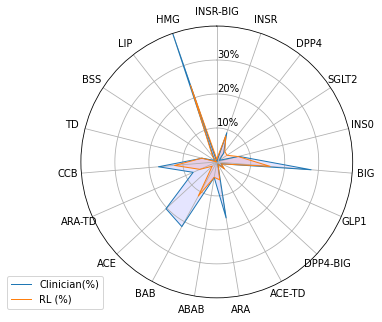

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
 
# Set data
# df_radar = pd.DataFrame({
# 'group': ['Clinician','RL'],
# 'var1': [38, 1.5],
# 'var2': [29, 10],
# 'var3': [8, 39],
# 'var4': [7, 31],
# 'var5': [28, 15],
# 'var6': [28, 15]
# })
 
dm_treatment_dict = {'antihyperglycemic,_biguanide_type': 'BIG',
                     'insulins': 'INS0',
                     'antihyperglycemic,insulin-release_stim.-biguanide': 'INSR-BIG',
                     'antihyperglycemic,_dpp-4_inhibitors': 'DPP4',
                     'antihypergly,incretin_mimetic(glp-1_recep.agonist)': 'GLP1',
                     'antihyperglycemic,_insulin-release_stimulant_type': 'INSR',
                     'antihyperglycemic,dpp-4_inhibitor-biguanide_combs.': 'DPP4-BIG',
                     'antihyperglycemc-sod/gluc_cotransport2(sglt2)inhib': 'SGLT2',
                     'antihyperglycemic,_alpha-glucosidase_inhibitors': 'AGI',
                     'antihyperglycemic,_thiazolidinedione_and_biguanide': 'TBIG',
                     'antihyperglycemic,thiazolidinedione(pparg_agonist)': 'PPARg',
                     'antihyperglycemic_-_dopamine_receptor_agonists': 'DRA',
                     'antihyperglycemic-sglt2_inhibitor-biguanide_combs.': 'SGLT2-BIG',
                     'antihyperglycemic,_sglt-2_and_dpp-4_inhibitor_comb': 'SGLT2-DPP4',
                     'antihyperglycemic,_thiazolidinedione-sulfonylurea': 'TS',
                     'antihypergly,dpp-4_enzyme_inhib.-thiazolidinedione': 'DPP4-T',
                     'antihypergly,insulin,long_act-glp-1_recept.agonist': 'LA-GLP1',
                     'antihyperglycemic,_amylin_analog-type': 'AA'}

hypertension_treatment_dict = {'antihypertensives,_ace_inhibitors': 'ACE',
                               'calcium_channel_blocking_agents': 'CCB',
                               'beta-adrenergic_blocking_agents': 'BAB',
                               'angiotensin_receptor_antag.-thiazide_diuretic_comb': 'ARA-TD',
                               'antihypertensives,_angiotensin_receptor_antagonist': 'ARA',
                               'thiazide_and_related_diuretics': 'TD',
                               'potassium_sparing_diuretics_in_combination': 'PSD',
                               'alpha/beta-adrenergic_blocking_agents': 'ABAB',
                               'antihyperlipid-_hmg-coa_ri-calcium_channel_blocker': 'AHCCC',
                               'ace_inhibitor-thiazide_or_thiazide-like_diuretic': 'ACE-TD',
                               'angioten.receptr_antag-calcium_chanl_blkr-thiazide': 'ARA-CCB-TD',
                               'angiotensin_receptor_blockr-calcium_channel_blockr': 'ARB-CCB',
                               'miotics_and_other_intraocular_pressure_reducers': 'MOTHER',
                               'renin_inhibitor,direct-angiotensin_receptr_antagon': 'RI',
                               'angiotensin_recept-neprilysin_inhibitor_comb(arni)': 'ARNI',
                               'beta-blockers_and_thiazide,thiazide-like_diuretics': 'BB-TD',
                               'bulk_chemicals': 'BC',
                               'renin_inhibitor,direct_and_thiazide_diuretic_comb': 'RI-TD',
                               'anti-inflammatory,_interleukin-1_beta_blockers': 'AI-BB'}

ascvd_treatment_dict = {'antihyperlip.hmg_coa_reduct_inhib-cholest.ab.inhib': 'HMG-CA',
                        'antihyperlipidemic-hmg_coa_reductase_inhib.-niacin': 'HMG-N',
                        'antihyperlipidemic_-_hmg_coa_reductase_inhibitors': 'HMG',
                        'antihyperlipidemic_-_pcsk9_inhibitors': 'PCSK9',
                        'bile_salt_sequestrants': 'BSS',
                        'lipotropics': 'LIP'}

index_rename_col = {'index':'group'}

df_radar = therapy_benefit[['Clinician(%)','RL(%)']].T
df_radar.reset_index(level=0, inplace=True)
df_radar.rename(columns= {**index_rename_col, **dm_treatment_dict, **hypertension_treatment_dict, **ascvd_treatment_dict} ,inplace=True)
df_radar
 
# ------- PART 1: Create background
 
# number of variable
def radar_plot(df_radar,ax=None, **kwargs):
    categories=list(df_radar)
    categories.remove('group')
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([10,20,30], ["10%","20%","30%"], color="black", size=10)
    plt.ylim(0,40)


    # ------- PART 2: Add plots

    # Plot each individual = each line of the data
    # I don't do a loop, because plotting more than 3 groups makes the chart unreadable

    # Ind1
    values=df_radar.loc[0].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label="Clinician(%)")
    ax.fill(angles, values, 'b', alpha=0.1)

    # Ind2
    values=df_radar.loc[1].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label="RL (%)")
    ax.fill(angles, values, 'r', alpha=0.1)

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.figure(figsize=(5,5))
radar_plot(df_radar)

In [34]:
df_radar

,group,INSR-BIG,INSR,DPP4,SGLT2,INS0,BIG,GLP1,DPP4-BIG,ACE-TD,ARA,ABAB,BAB,ACE,ARA-TD,CCB,TD,BSS,LIP,HMG
0,Clinician(%),0.155602,9.069913,3.276442,0.872935,6.690871,27.850740,1.341697,2.832146,0.666445,16.716903,4.63967,21.632545,20.318249,7.605887,17.22481,4.463517,0.848469,1.426838,40.010178
1,RL(%),0.836726,8.125538,3.858725,3.590582,6.484381,15.759806,1.440539,3.081696,0.786816,5.330580,4.61814,11.410788,1.871134,5.428443,12.47162,4.538871,0.019573,1.969976,23.866750


In [35]:
predicted_cases[list(dm_treatment) + list(hypertension_treatments) + list(ascvd_treatment)].sum()[predicted_cases[list(dm_treatment) + list(hypertension_treatments) + list(ascvd_treatment)].mean() > 0.0]


antihyperglycemic,insulin-release_stim.-biguanide       159.0
antihyperglycemic,_insulin-release_stimulant_type      9268.0
antihyperglycemic,_dpp-4_inhibitors                    3348.0
antihyperglycemc-sod/gluc_cotransport2(sglt2)inhib      892.0
antihyperglycemic,thiazolidinedione(pparg_agonist)     1126.0
insulins                                               6837.0
antihyperglycemic,_biguanide_type                     28459.0
antihypergly,incretin_mimetic(glp-1_recep.agonist)     1371.0
antihyperglycemic,dpp-4_inhibitor-biguanide_combs.     2894.0
ace_inhibitor-thiazide_or_thiazide-like_diuretic        681.0
antihypertensives,_angiotensin_receptor_antagonist    17082.0
alpha/beta-adrenergic_blocking_agents                  4741.0
beta-adrenergic_blocking_agents                       22105.0
beta-blockers_and_thiazide,thiazide-like_diuretics      554.0
antihypertensives,_ace_inhibitors                     20762.0
angiotensin_receptor_antag.-thiazide_diuretic_comb     7772.0
angioten

In [36]:
ai_policy_count = predicted_cases[labels].sum()
clinician_policy_count = predicted_cases[list(dm_treatment) + list(hypertension_treatments) + list(ascvd_treatment)].sum()[predicted_cases[list(dm_treatment) + list(hypertension_treatments) + list(ascvd_treatment)].mean() > 0.0]
RL_histogram = pd.DataFrame(data={'RL': ai_policy_count.to_list()}, index=label_list)
clinician_histogram = pd.DataFrame(data={'Clinician': clinician_policy_count.to_list()}, index=clinician_policy_count.index.to_numpy())

df_radar = clinician_histogram.merge(RL_histogram,left_index=True, right_index=True).sort_values(by='Clinician',ascending=False).T

df_radar.reset_index(level=0, inplace=True)
df_radar.rename(columns= {**index_rename_col, **dm_treatment_dict, **hypertension_treatment_dict, **ascvd_treatment_dict} ,inplace=True)
df_radar


,group,HMG,BIG,BAB,ACE,CCB,ARA,INSR,ARA-TD,INS0,ABAB,TD,DPP4,DPP4-BIG,LIP,GLP1,SGLT2,BSS,ACE-TD,INSR-BIG
0,Clinician,40884.0,28459.0,22105.0,20762.0,17601.0,17082.0,9268.0,7772.0,6837.0,4741.0,4561.0,3348.0,2894.0,1458.0,1371.0,892.0,867.0,681.0,159.0
1,RL,24388.0,16104.0,11660.0,1912.0,12744.0,5447.0,8303.0,5547.0,6626.0,4719.0,4638.0,3943.0,3149.0,2013.0,1472.0,3669.0,20.0,804.0,855.0


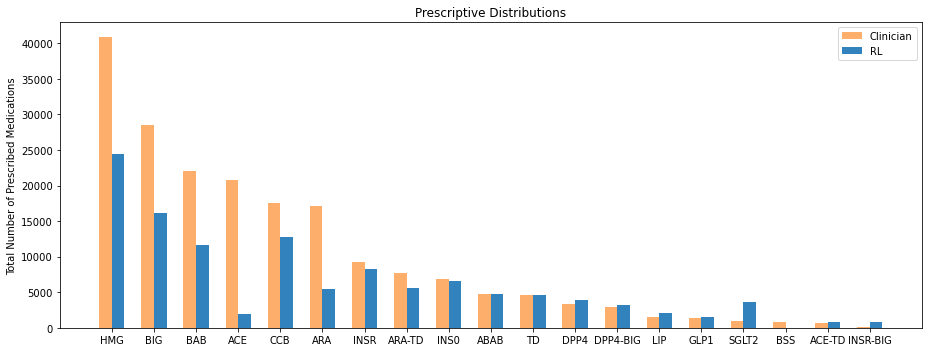

In [38]:
# df_radar.plot(kind='barh', figsize=(6,10))


bar_labels = list(df_radar.columns)[1:]
men_means = df_radar.loc[0].to_list()[1:]
women_means = df_radar.loc[1].to_list()[1:]


x = np.arange(len(bar_labels))  # the label locations
width = 0.3  # the width of the bars
fig, ax = plt.subplots(figsize=(13,5))
cmap = plt.get_cmap("tab20c")
outer_colors = cmap(6)
in_colors = cmap(0)
rects1 = ax.bar(x - width/2, men_means, width, label='Clinician',color=outer_colors)
rects2 = ax.bar(x + width/2, women_means, width, label='RL',color=in_colors)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Total Number of Prescribed Medications')
ax.set_title('Prescriptive Distributions')
ax.set_xticks(x)
ax.set_xticklabels(bar_labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


# autolabel(rects1)
# autolabel(rects2)
fig.tight_layout()


plt.savefig('distribution1.png')
plt.savefig('distribution2.pdf')
plt.savefig('distribution3.svg')



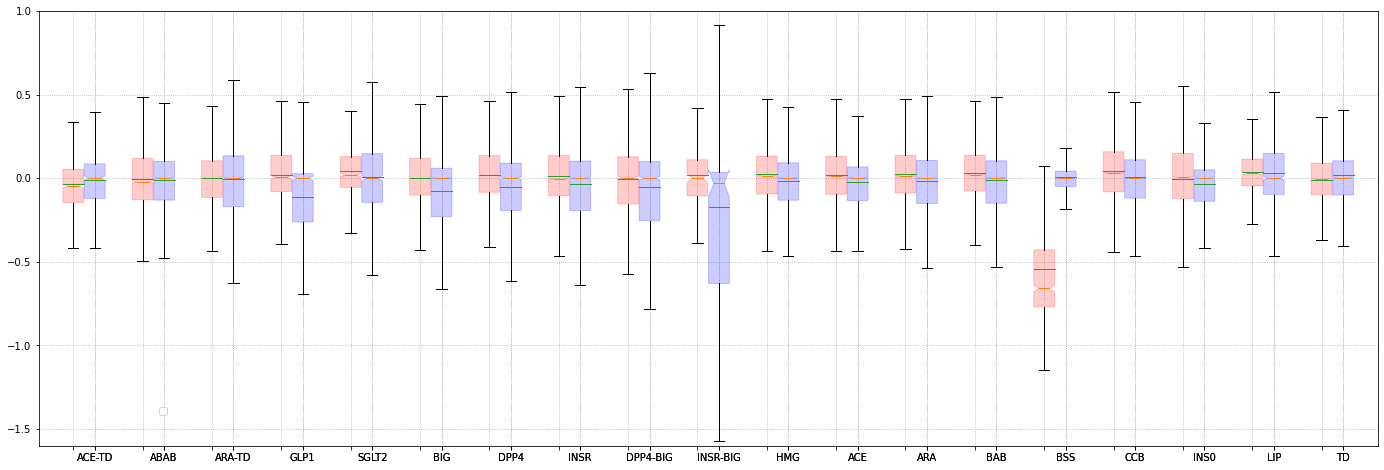

In [39]:
regimen_data_RL = [regimen[s][0] for s in label_list]
regimen_data_clinician = [regimen[s][1] for s in label_list]
# --- Combining your data:
data_group1 = regimen_data_RL
data_group2 = regimen_data_clinician
# --- Labels for your data:
treatment_dict = {**dm_treatment_dict, **hypertension_treatment_dict, **ascvd_treatment_dict}

# --- Labels for your data:
group_labels_list = [treatment_dict[s] for s in label_list] # ['RL','Clinician']
xlocations  = range(len(data_group1))
width       = 0.3
symbol      = 'r+'
ymin        = -1.6
ymax        = 1

plt.figure(figsize=(24,8))
ax = plt.gca()
ax.set_ylim(ymin,ymax)
ax.set_xticklabels(group_labels_list, rotation=0 )
ax.grid(True, linestyle='dotted')
ax.set_axisbelow(True)
ax.set_xticks(xlocations)
# plt.xlabel('X axis label')
# plt.ylabel('Y axis label')
# plt.title('title')

# --- Offset the positions per group:
positions_group1 = [x-(width+0.01) for x in xlocations]
positions_group2 = xlocations

plt.boxplot(data_group1, 
            sym=symbol,
            labels=['']*len(group_labels_list),
            positions=positions_group1, 
            widths=width, 
            showfliers=False,
            meanline=True,
          notch=True,  
#           vert=True, 
#           whis=1.5,
#           bootstrap=None, 
#           usermedians=None, 
#           conf_intervals=None,
            patch_artist=True,
            boxprops ={'color':'r','facecolor':"r", 'alpha':0.2},
            showmeans=True,
            medianprops={'linewidth':1},
            meanprops={'linewidth':1, 'linestyle':'solid'}
            )

plt.boxplot(data_group2, 
            labels=group_labels_list,
            sym=symbol,
            positions=positions_group2, 
            widths=width, 
            showfliers=False,
            meanline=True,
          notch=True,  
#           vert=True, 
#           whis=1.5,
#           bootstrap=None, 
#           usermedians=None, 
#           conf_intervals=None,
            patch_artist=True,
            boxprops ={'color':'b','facecolor':"b", 'alpha':0.2},
            showmeans=True,
            medianprops={'linewidth':1},
            meanprops={'linewidth':1, 'linestyle':'solid'}
            )

# plt.savefig('boxplot_grouped.png')  
# plt.savefig('boxplot_grouped.pdf')    # when publishing, use high quality PDFs
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))# uncomment to show the plot. 
plt.show()         


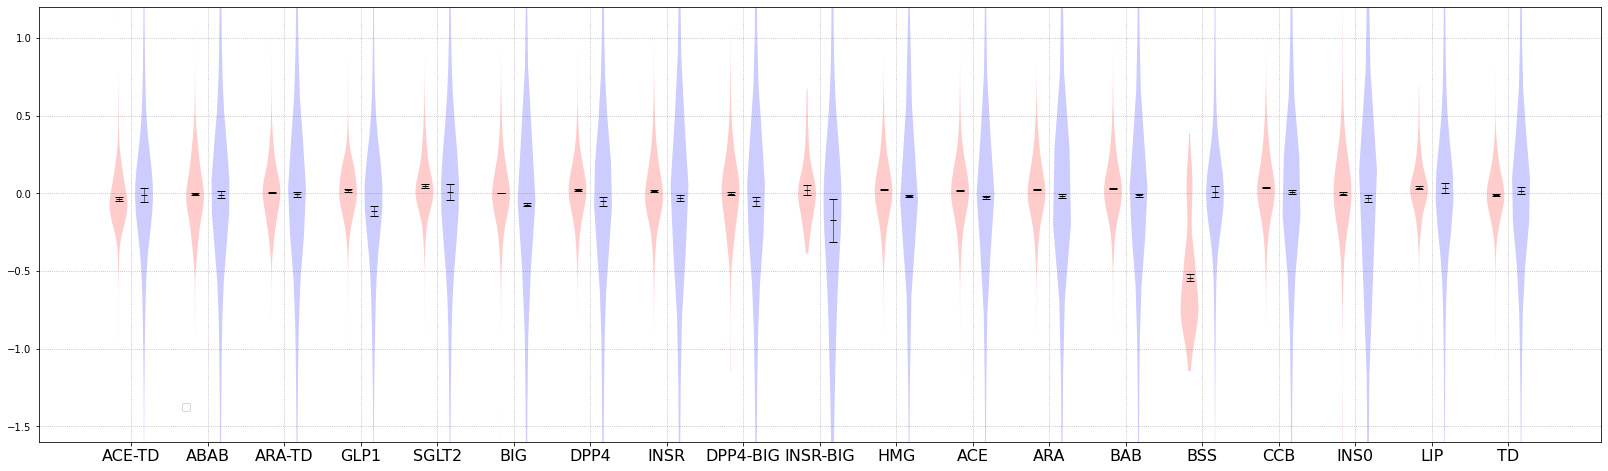

In [40]:
# --- Combining your data:
data_group1 = regimen_data_RL
data_group2 = regimen_data_clinician

# --- Labels for your data:
treatment_dict = {**dm_treatment_dict, **hypertension_treatment_dict, **ascvd_treatment_dict}
# --- Labels for your data:
group_labels_list = [treatment_dict[s] for s in label_list] # ['RL','Clinician']

width       = 0.3
symbol      = 'r+'
ymin        = -1.6
ymax        = 1.2

pos1 = []
pos2 = []
xlocations = []

for i in range(len(label_list)):
    s = 1 + i * 3
    pos1.append(s)
    pos2.append(s+1)
    xlocations.append(s+0.5)
    
plt.figure(figsize=(28,8))
ax = plt.gca()
ax.set_ylim(ymin,ymax)
ax.grid(True, linestyle='dotted')
ax.set_axisbelow(True)
# plt.xlabel('X axis label')
# plt.ylabel('Y axis label')
# plt.title('title')
ax.set_xticks(xlocations)

# lab_in_temp = 0
# group_labels_list_new = []
# for s in range(len(label_list) * 2):
#     if s in xlocations:
#         group_labels_list_new.append(group_labels_list[lab_in_temp])
#     else:
#         group_labels_list_new.append("")
#     lab_in_temp += 1

ax.set_xticklabels(group_labels_list, rotation=0,fontsize=16)
y1 = [np.mean(s) for s in data_group1]
dy1 = [np.std(s) / np.sqrt(len(s)) * 1.96 for s in data_group1]
y2 = [np.mean(s) for s in data_group2]
dy2 = [np.std(s) / np.sqrt(len(s)) * 1.96 for s in data_group2]

plt.errorbar(pos1+pos2, y1+y2, yerr=dy1+dy2, fmt='_', color='black',
              elinewidth=0.5, capsize=4)

# plt.errorbar(, , yerr=, fmt='none', color='black',
#               elinewidth=1, capsize=1, barsabove=True)

violin_parts1 = plt.violinplot(data_group1, pos1, points=60, widths=0.7,
                     showmeans=False, showextrema=False, # showmedians=True,
                     bw_method=0.4)
violin_parts2 = plt.violinplot(data_group2, pos2, points=60, widths=0.7,
                     showmeans=False, showextrema=False, # showmedians=True,
                     bw_method=0.4)

# Make the violin body blue with a red border:
for vp in violin_parts1['bodies']:
    vp.set_facecolor('r')
#     vp.set_edgecolor(rrred)
#     vp.set_linewidth(1)
    vp.set_alpha(0.2)

for vp in violin_parts2['bodies']:
    vp.set_facecolor('b')
#     vp.set_edgecolor(rrred)
#     vp.set_linewidth(1)
    vp.set_alpha(0.2)
    
# --- Offset the positions per group:
# positions_group1 = [x-(width+0.01) for x in xlocations]
# positions_group2 = xlocations

# plt.boxplot(data_group1, 
#             sym=symbol,
#             labels=['']*len(group_labels_list),
#             positions=positions_group1, 
#             widths=width, 
#             showfliers=False,
#             meanline=True,
#           notch=True,  
# #           vert=True, 
# #           whis=1.5,
# #           bootstrap=None, 
# #           usermedians=None, 
# #           conf_intervals=None,
#             patch_artist=True,
#             boxprops ={'color':'r','facecolor':"r", 'alpha':0.2},
#             showmeans=True,
#             medianprops={'linewidth':1},
#             meanprops={'linewidth':1, 'linestyle':'solid'}
#             )

# plt.boxplot(data_group2, 
#             labels=group_labels_list,
#             sym=symbol,
#             positions=positions_group2, 
#             widths=width, 
#             showfliers=False,
#             meanline=True,
#             notch=True,  
# #           vert=True, 
# #           whis=1.5,
# #           bootstrap=None, 
# #           usermedians=None, 
# #           conf_intervals=None,
#             patch_artist=True,
#             boxprops ={'color':'b','facecolor':"b", 'alpha':0.2},
#             showmeans=True,
#             medianprops={'linewidth':1},
#             meanprops={'linewidth':1, 'linestyle':'solid'}
#             )
# plt.errorbar(x, y + 3, yerr=yerr, label='both limits (default)')
# plt.savefig('boxplot_grouped.png')  
# plt.savefig('boxplot_grouped.pdf')    # when publishing, use high quality PDFs
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))# uncomment to show the plot. 


plt.savefig('violinplot1.png')
plt.savefig('violinplot2.pdf')
plt.savefig('violinplot3.svg')

plt.show() 

In [41]:
annotation_count = pd.DataFrame(data={'clinician':gain_bp_systolic_clincian,'AI': gain_bp_systolic_AI, 'reward': gain_reward}).groupby(['clinician','AI']).count().astype('int32').reset_index().pivot(index='clinician', columns='AI', values='reward')
heatmap_data = pd.DataFrame(data={'clinician':gain_bp_systolic_clincian,'AI': gain_bp_systolic_AI, 'reward': gain_reward}).groupby(['clinician','AI']).mean().reset_index().pivot(index='clinician', columns='AI', values='reward')


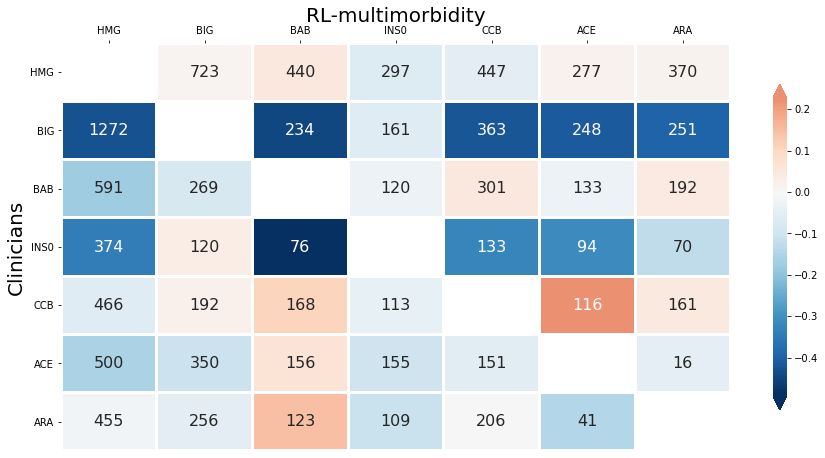

In [42]:
yticklabels_list = [decode_to_treatment(str(target_set[i]), data[label_cols].columns) for i in range(100)]
xticklabels_list = [decode_to_treatment(str(target_set[i]), data[label_cols].columns) for i in list(heatmap_data.columns)]
treatment_dict = {**dm_treatment_dict, **hypertension_treatment_dict, **ascvd_treatment_dict}
yticklabels = [" & ".join([treatment_dict[i] for i in s]) for s in yticklabels_list]
xticklabels = [" & ".join([treatment_dict[i] for i in s]) for s in xticklabels_list]

import seaborn as sns
plt.figure(figsize = (15,7.5))

# Create a custom colormap for the heatmap values
cmap = sns.diverging_palette(h_neg=210, h_pos=400, s=90, l=30, as_cmap=True)

cbar_kws = {"shrink":.8,
           'extend':'both'} 

limit_therapy = 7
ax = sns.heatmap(
    -heatmap_data.iloc[:limit_therapy,:limit_therapy], 
    center=0, cmap='RdBu_r', annot_kws={'size':16},
    annot=annotation_count.iloc[:limit_therapy,:limit_therapy],
    linewidth = 2,
    fmt='g',
    cbar_kws=cbar_kws,
    yticklabels =yticklabels[:limit_therapy],
    xticklabels=xticklabels[:limit_therapy])
plt.yticks(rotation=0)
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
plt.xlabel("RL-multimorbidity", fontsize = 20)
plt.ylabel("Clinicians", fontsize = 20)


plt.savefig('foo1.png')
plt.savefig('foo2.pdf')
plt.savefig('foo3.svg')

plt.show()

In [43]:
tem = (heatmap_data.iloc[:limit_therapy,:limit_therapy] == np.nanmax(heatmap_data.iloc[:limit_therapy,:limit_therapy][annotation_count>0])).values
for i in range(tem.shape[0]):
    for j in range(tem.shape[1]):
        if tem[i,j]:
            print(i,j)
            print(yticklabels_list[i],xticklabels_list[j])


3 2
['insulins'] ['beta-adrenergic_blocking_agents']


In [45]:
heatmap_data_sbp = pd.DataFrame(data={'clinician':gain_bp_systolic_clincian,'AI': gain_bp_systolic_AI, 'reward': gain_bp_systolic}).groupby(['clinician','AI']).mean().reset_index().pivot(index='clinician', columns='AI', values='reward')
heatmap_data_a1c = pd.DataFrame(data={'clinician':gain_bp_systolic_clincian,'AI': gain_bp_systolic_AI, 'reward': gain_hemoglobin_a1c}).groupby(['clinician','AI']).mean().reset_index().pivot(index='clinician', columns='AI', values='reward')
heatmap_data_ascvd = pd.DataFrame(data={'clinician':gain_bp_systolic_clincian,'AI': gain_bp_systolic_AI, 'reward': gain_risk_ascvd}).groupby(['clinician','AI']).mean().reset_index().pivot(index='clinician', columns='AI', values='reward')
heatmap_data_sbp_RL = pd.DataFrame(data={'clinician':gain_bp_systolic_clincian,'AI': gain_bp_systolic_AI, 'reward': RL_bp_systolic}).groupby(['clinician','AI']).mean().reset_index().pivot(index='clinician', columns='AI', values='reward')
heatmap_data_a1c_RL = pd.DataFrame(data={'clinician':gain_bp_systolic_clincian,'AI': gain_bp_systolic_AI, 'reward': RL_hemoglobin_a1c}).groupby(['clinician','AI']).mean().reset_index().pivot(index='clinician', columns='AI', values='reward')
heatmap_data_ascvd_RL = pd.DataFrame(data={'clinician':gain_bp_systolic_clincian,'AI': gain_bp_systolic_AI, 'reward': RL_risk_ascvd}).groupby(['clinician','AI']).mean().reset_index().pivot(index='clinician', columns='AI', values='reward')
heatmap_data_sbp_clinician = pd.DataFrame(data={'clinician':gain_bp_systolic_clincian,'AI': gain_bp_systolic_AI, 'reward': clinician_bp_systolic}).groupby(['clinician','AI']).mean().reset_index().pivot(index='clinician', columns='AI', values='reward')
heatmap_data_a1c_clinician = pd.DataFrame(data={'clinician':gain_bp_systolic_clincian,'AI': gain_bp_systolic_AI, 'reward': clinician_hemoglobin_a1c}).groupby(['clinician','AI']).mean().reset_index().pivot(index='clinician', columns='AI', values='reward')
heatmap_data_ascvd_clinician = pd.DataFrame(data={'clinician':gain_bp_systolic_clincian,'AI': gain_bp_systolic_AI, 'reward': clinician_risk_ascvd}).groupby(['clinician','AI']).mean().reset_index().pivot(index='clinician', columns='AI', values='reward')


In [ ]:
annotation_count.to_csv('annotation_count.csv')
heatmap_data.to_csv('heatmap_data.csv')